![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Healthcare/5.1.Spark_OCR_Multi_Modals.ipynb)

# Spark OCR 


## Blogposts and videos

- [How to Setup Spark OCR on UBUNTU - Video](https://www.youtube.com/watch?v=cmt4WIcL0nI)

- [Installing Spark NLP and Spark OCR in air-gapped networks (offline mode)
](https://medium.com/spark-nlp/installing-spark-nlp-and-spark-ocr-in-air-gapped-networks-offline-mode-f42a1ee6b7a8)

- [Table Detection & Extraction in Spark OCR](https://medium.com/spark-nlp/table-detection-extraction-in-spark-ocr-50765c6cedc9)

- [Signature Detection in Spark OCR](https://medium.com/spark-nlp/signature-detection-in-spark-ocr-32f9e6f91e3c)

- [GPU image pre-processing in Spark OCR](https://medium.com/spark-nlp/gpu-image-pre-processing-in-spark-ocr-3-1-0-6fc27560a9bb)

**More examples here**

https://github.com/JohnSnowLabs/spark-ocr-workshop

**Colab Setup**

In [ ]:
import json, os
from google.colab import files

if 'spark_jsl.json' not in os.listdir():
  license_keys = files.upload()
  os.rename(list(license_keys.keys())[0], 'spark_ocr.json')

with open('spark_ocr.json') as f:
    license_keys = json.load(f)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [ ]:
# Installing pyspark and spark-nlp
! pip install --upgrade -q pyspark==3.2.1 spark-nlp==$PUBLIC_VERSION

# Installing Spark OCR
! pip install spark-ocr==$OCR_VERSION --extra-index-url=https://pypi.johnsnowlabs.com/$SPARK_OCR_SECRET --upgrade

<b><h1><font color='darkred'>!!! ATTENTION !!! </font><h1><b>

<b>After running previous cell, <font color='darkred'>RESTART the COLAB RUNTIME </font> and go ahead.<b>

In [1]:
import json, os

with open("spark_ocr.json", 'r') as f:
  license_keys = json.load(f)

# Adding license key-value pairs to environment variables
os.environ.update(license_keys)

# Defining license key-value pairs as local variables
locals().update(license_keys)

In [2]:
import sparkocr
import sys
from pyspark.sql import SparkSession
from sparkocr import start
import base64
from sparkocr.transformers import *
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from sparkocr.enums import *
from sparkocr.utils import display_images

In [3]:
# Start spark
spark = sparkocr.start(secret=SPARK_OCR_SECRET, 
                       nlp_version=PUBLIC_VERSION
                       )

Spark version: 3.2.1
Spark NLP version: 4.2.4
Spark OCR version: 4.2.4



## Working with tables

### Table Detection

**Load images**

In [4]:
!wget -q raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/tab_images/cTDaR_t10168.jpg -P table_image/
!wget -q raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/tab_images/cTDaR_t10011.jpg -P table_image/

**Read and display images**

In [5]:
from sparkocr.utils import display_tables


    Image #0:
    Origin: file:/content/table_image/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


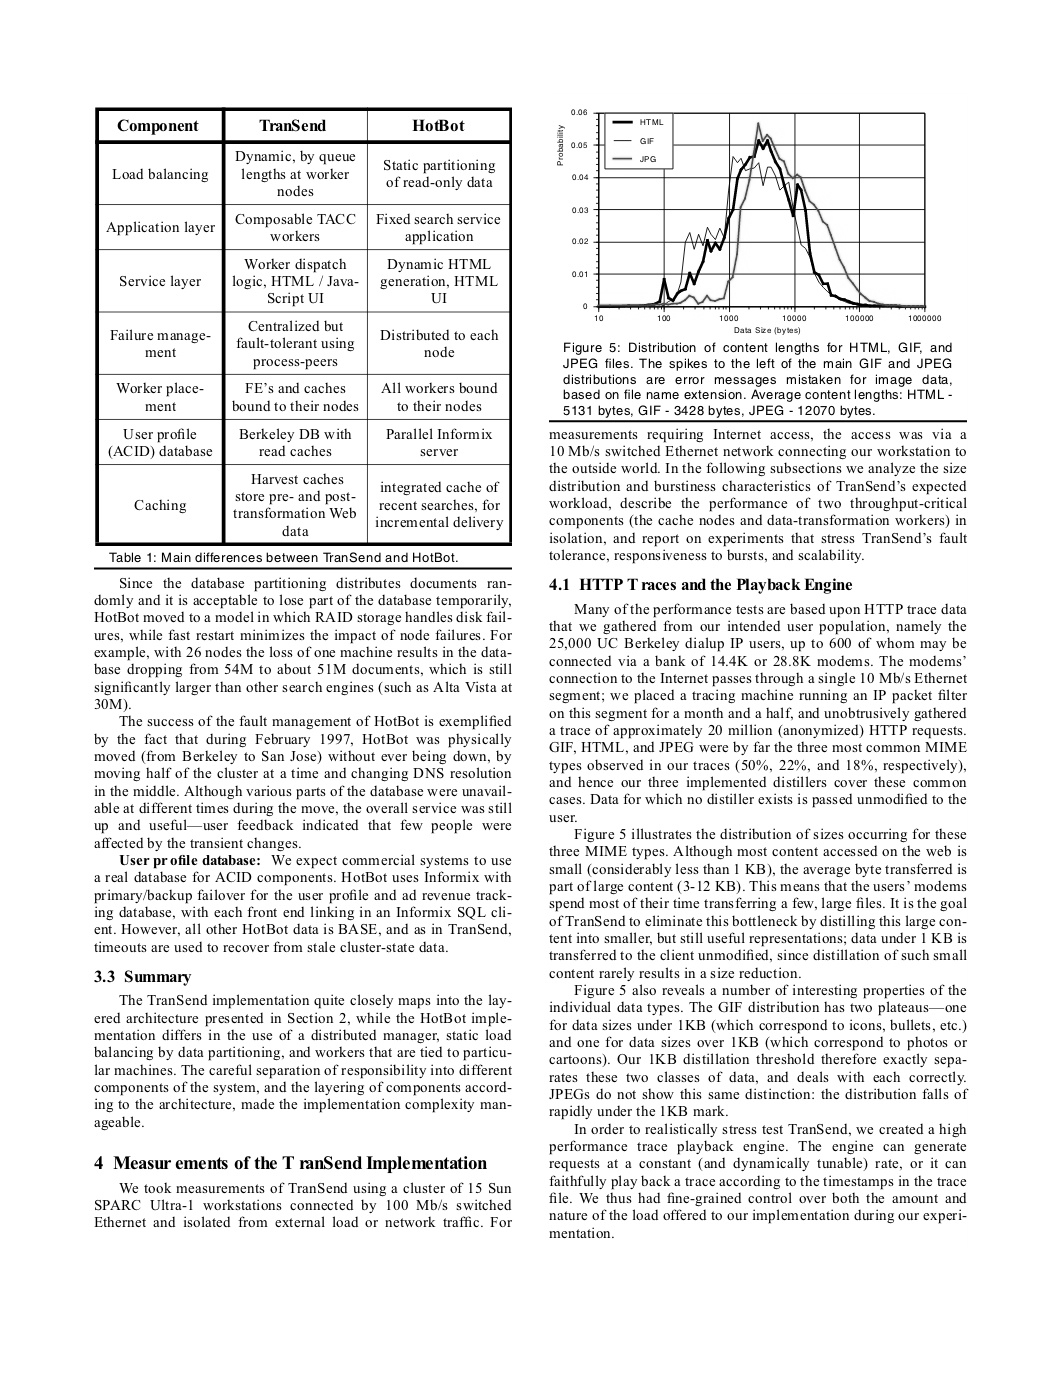


    Image #1:
    Origin: file:/content/table_image/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


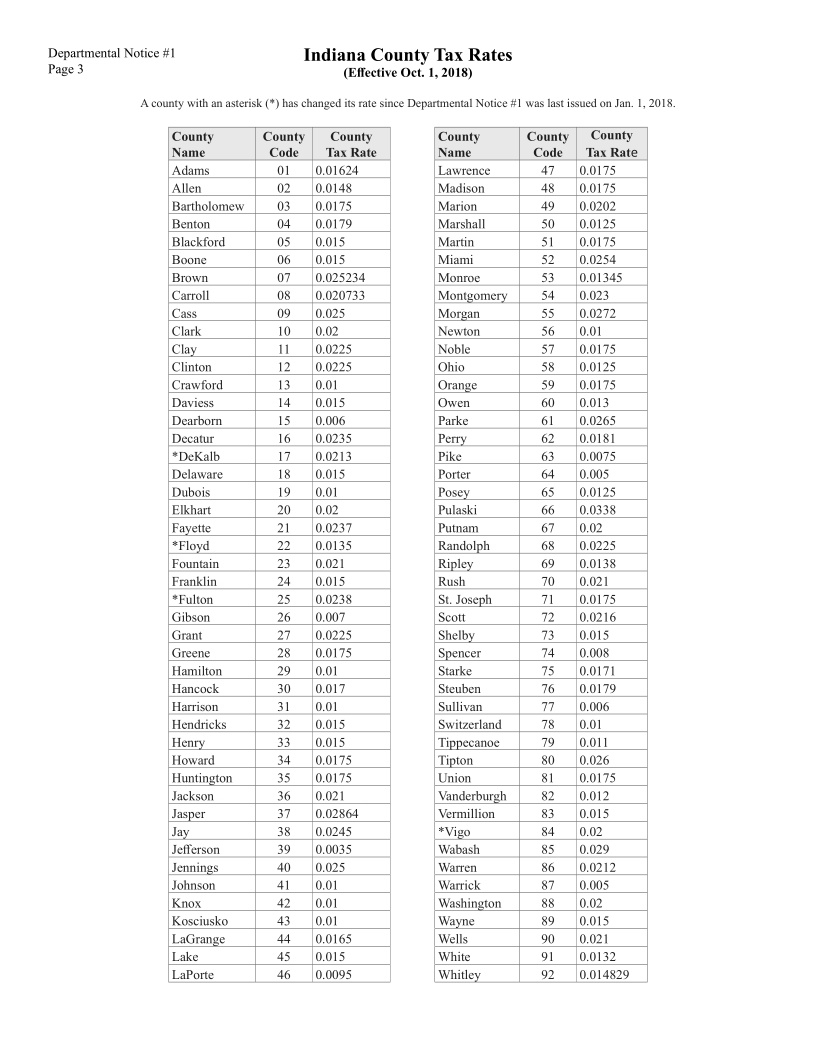

In [6]:
image_df = spark.read.format("binaryFile").load("/content/table_image/*.jpg")

display_images(BinaryToImage().transform(image_df), "image")

**Create OCR Pipeline**

In [7]:
binary_to_image = BinaryToImage() 
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("table_regions")

draw_regions = ImageDrawRegions()
draw_regions.setInputCol("image")
draw_regions.setInputRegionsCol("table_regions")
draw_regions.setOutputCol("image_with_regions")
draw_regions.setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    draw_regions
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


**Show results**


    Image #0:
    Origin: file:/content/table_image/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


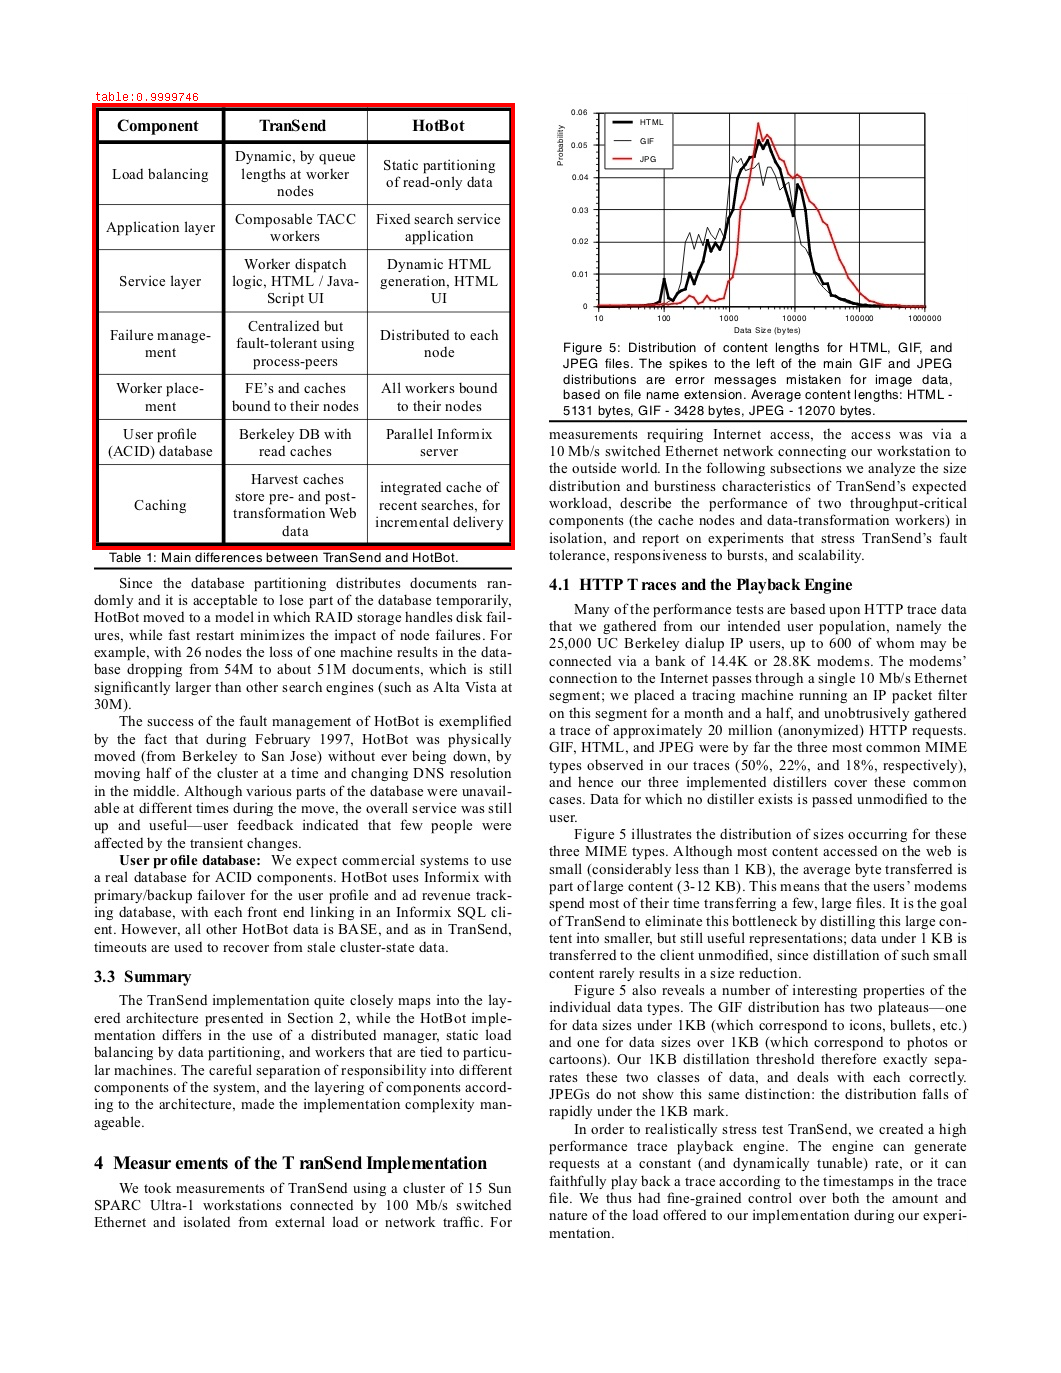


    Image #1:
    Origin: file:/content/table_image/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


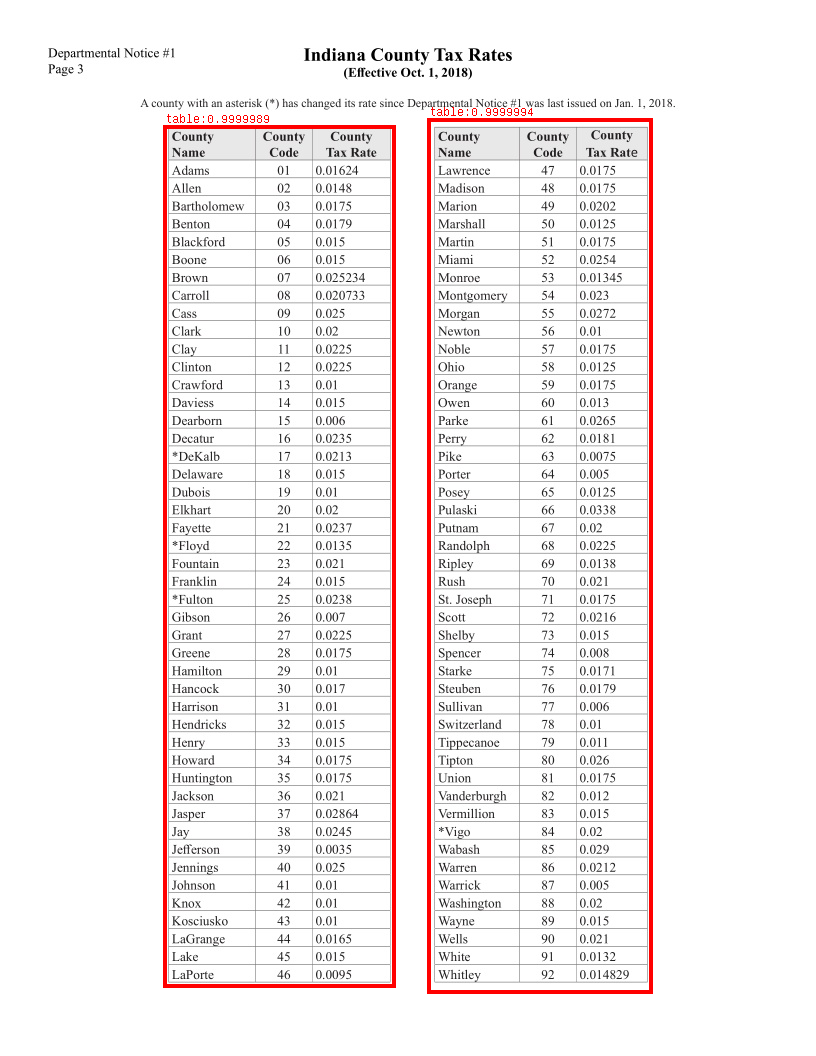

In [8]:
result =  pipeline.transform(image_df)
display_images(result, "image_with_regions")

### Table Recognition

In [9]:
from pyspark.sql.functions import desc, row_number, monotonically_increasing_id
from pyspark.sql.window import Window
import pyspark.sql.functions as f

**Load and display the images.**


    Image #0:
    Origin: file:/content/table_image/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 1061 px
    Height: 1373 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


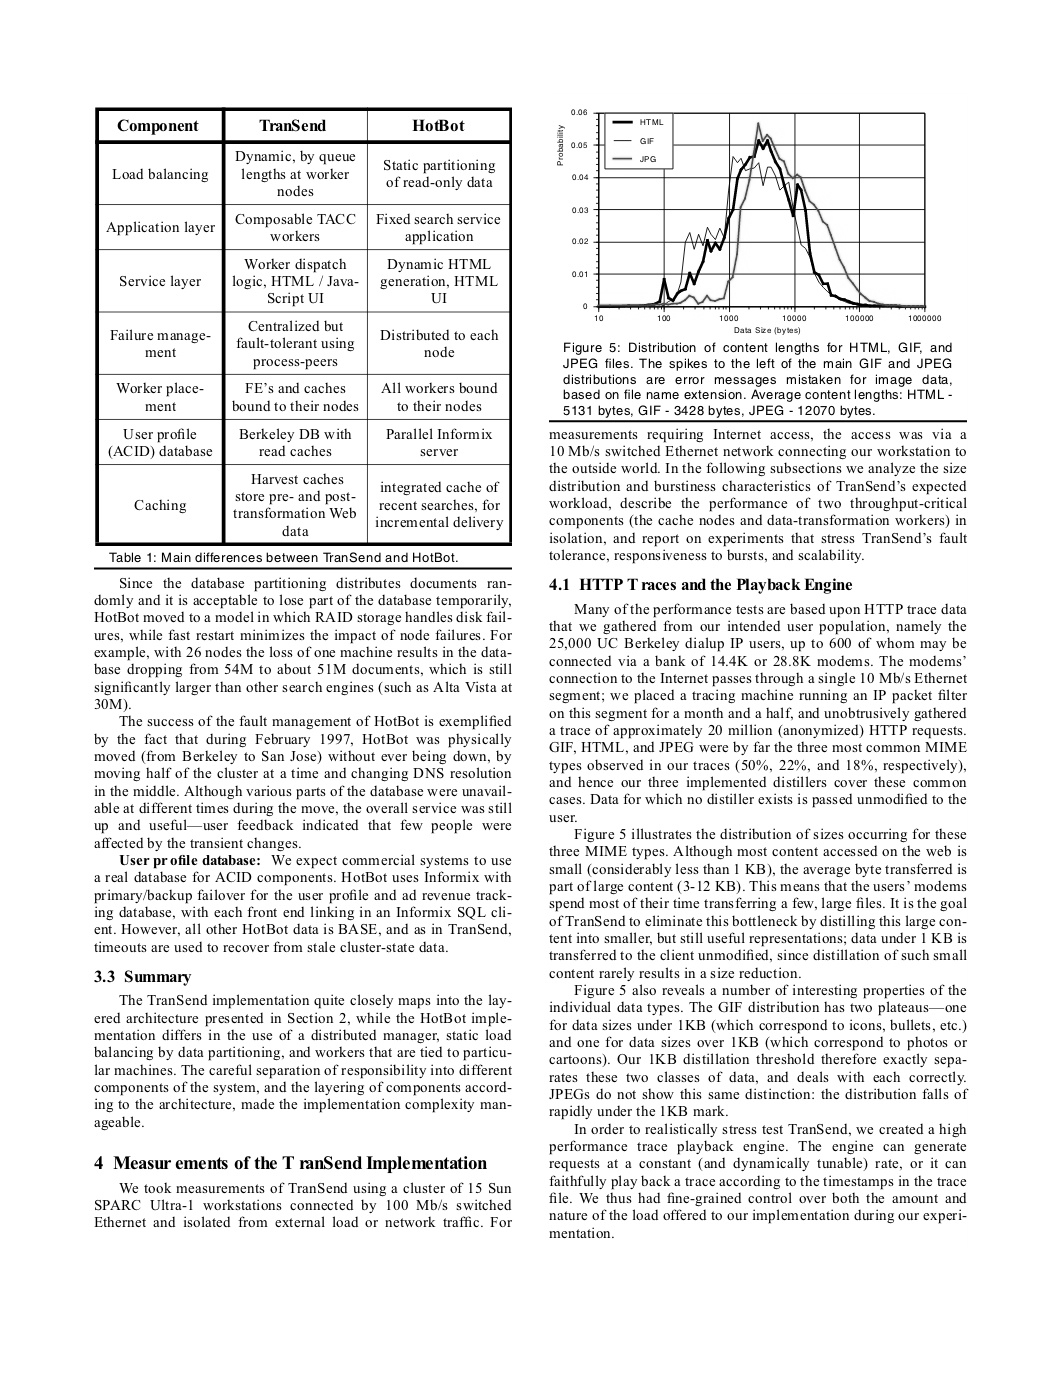


    Image #1:
    Origin: file:/content/table_image/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 816 px
    Height: 1056 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


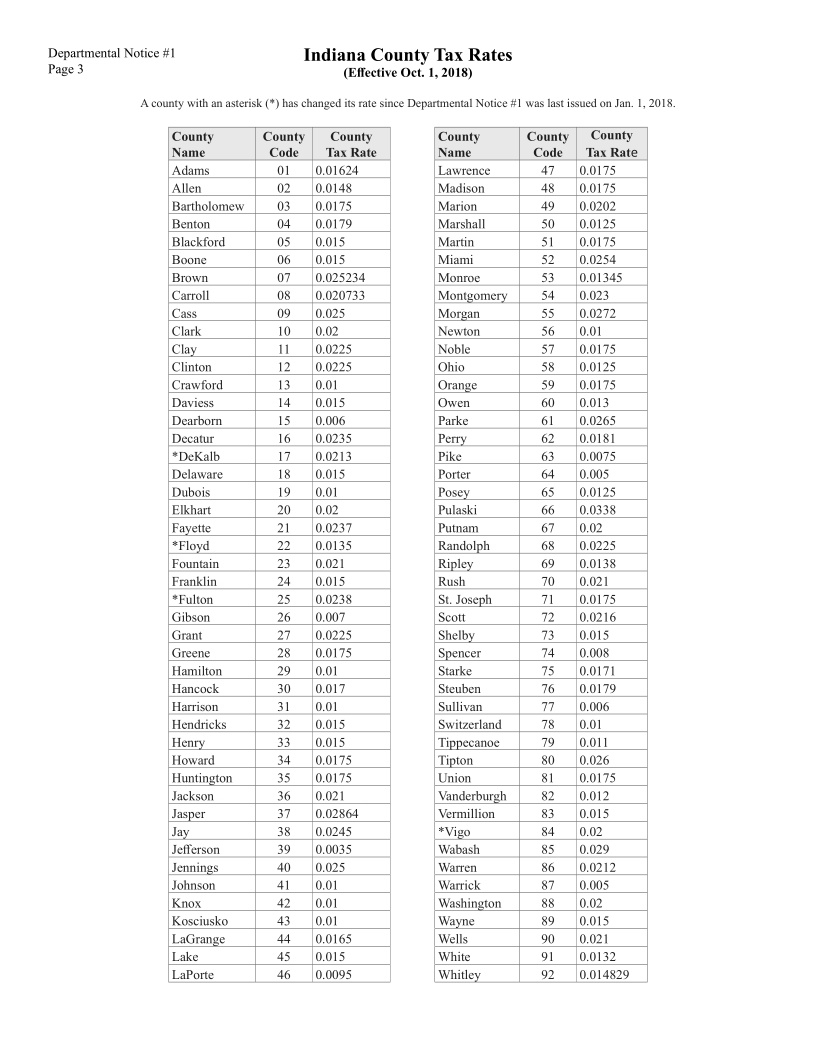

In [10]:
image_df= spark.read.format("binaryFile").load("table_image")

# add index to the dataframe
image_df_with_seq_id = image_df.withColumn('index', row_number().over(Window.orderBy(monotonically_increasing_id())) - 1)

display_images(BinaryToImage().transform(image_df), "image")

**Create OCR pipeline.**

In [11]:
binary_to_image = BinaryToImage()
# need set image type for correct work TableDetection model
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

table_detector = ImageTableDetector.pretrained("general_model_table_detection_v2", "en", "clinical/ocr")
table_detector.setInputCol("image")
table_detector.setOutputCol("region")

splitter = ImageSplitRegions()
splitter.setInputCol("image")
splitter.setInputRegionsCol("region")
splitter.setOutputCol("table_image")
splitter.setDropCols("image")
splitter.setImageType(ImageType.TYPE_BYTE_GRAY)

scaler = ImageScaler()
scaler.setInputCol("table_image")
scaler.setOutputCol("scaled_image")
scaler.setScaleFactor(2)

cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("scaled_image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)

table_recognition = ImageCellsToTextTable()
table_recognition.setInputCol("scaled_image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(1)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')


pipeline = PipelineModel(stages=[
    binary_to_image,
    table_detector,
    splitter,
    scaler,
    cell_detector,
    table_recognition
])

general_model_table_detection_v2 download started this may take some time.
Approximate size to download 264.7 MB


**Run the pipeline and display the tables in the images.**


    Image #0:
    Origin: file:/content/table_image/cTDaR_t10168.jpg
    Resolution: 0 dpi
    Width: 419 px
    Height: 443 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


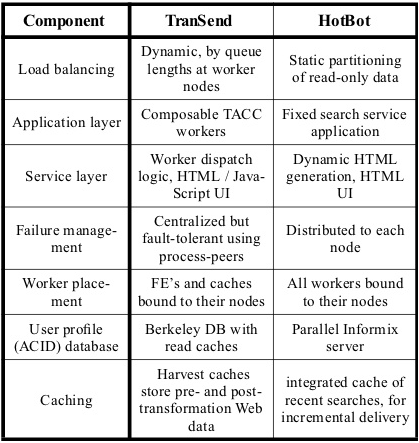


    Image #1:
    Origin: file:/content/table_image/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 222 px
    Height: 872 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


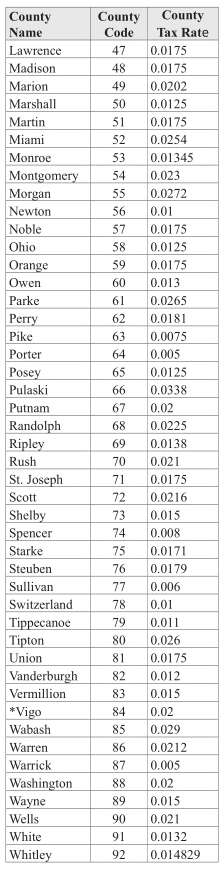


    Image #2:
    Origin: file:/content/table_image/cTDaR_t10011.jpg
    Resolution: 0 dpi
    Width: 229 px
    Height: 859 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


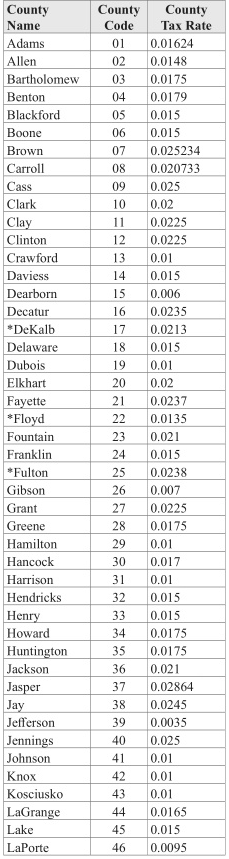

In [12]:
results = pipeline.transform(image_df_with_seq_id).cache()
display_images(results, "table_image")

**Display recognized tables**

In [13]:
display_tables(results)

Filename: cTDaR_t10168.jpg
Page:     0
Table:    0


col0  \
0                                          Component   
1                                     Load balancing   
2                                  Application layer   
3                   Service layerFailure manage-ment   
4   Centralized butfault-tolerant usingprocess-peers   
5                    All workers boundto their nodes   
6                            Parallel Informixserver   
7  integrated cache ofrecent searches, forincreme...   

                                          col1  \
0                                     TranSend   
1      Dynamic, by queuelengths at workernodes   
2                       Composable TACCworkers   
3  Worker dispatchlogic, HTML / Java-Script UI   
4                                         None   
5                  User profile(ACID) database   
6                                      Caching   
7                                         None   

                                                col2  
0                                             HotBot  
1               Static partitioningof read-only data  
2                    Fixed search serviceapplication  
3  Dynamic HTMLgeneration, HTMLUIDistributed to e...  
4                                               None  
5                        Berkeley DB withread caches  
6  Harvest cachesstore pre- and post-transformati...  
7                                               None

Filename: cTDaR_t10011.jpg
Page:     0
Table:    0


col0        col1            col2
0    CountyName  CountyCode  CountyTax Rate
1      Lawrence          47          0.0175
2       Madison          48          0.0175
3        Marion          49          0.0202
4      Marshall          50          0.0125
5        Martin         S51          0.0175
6         Miami          52          0.0254
7        Monroe          53         0.01345
8    Montgomery          54           0.023
9        Morgan          55          0.0272
10       Newton          56            0.01
11        Noble          57          0.0175
12         Ohio          58          0.0125
13       Orange          59          0.0175
14         Owen          60           0.013
15        Parke          61          0.0265
16        Perry          62          O.O181
17         Pike          63          0.0075
18       Porter          64           0.005
19        Posey          65          0.0125
20      Pulaski          66          0.0338
21       Putnam          67            0.02
22     Randolph          68          0.0225
23       Riplev          69          0.0138
24         Rush          70           0.021
25   St. Joseph          71          0.0175
26        Scott          72          0.0216
27       Shelby          73           0.015
28      Spencer          74           0.008
29       Starke          75          0.0171
30      Steuben          76          0.0179
31     Sullivan          77           0.006
32  Switzerland          78            0.01
33   Tippecanoe          79           0.011
34       Tipton          80           0.026
35        Union         R81          0.0175
36  Vanderburgh          &2           0.012
37   Vermillion          83           0.015
38        *Vigo          &4            0.02
39       Wabash          &5           0.029
40       Warren          86          0.0212
41      Warrick          87           0.005
42   Washineton          88            0.02
43        Wayne          go           0.015
44        Wells          90           0.021
45        White          91          0.0132
46      Whitley          9?        0.014829

Filename: cTDaR_t10011.jpg
Page:     0
Table:    1


col0        col1            col2
0    CountyName  CountyCode  CountyTax Rate
1         Adams          ol         0.01624
2         Allen          02          0.0148
3   Bartholomew          03          0.0175
4        Benton          04          0.0179
5     Blackford          os           0.015
6         Boone          06           0.015
7         Brown          07        0.025234
8       Carroll          og        0.020733
9          Cass          09           0.025
10        Clark          10            0.02
11         Clay          ll          0.0225
12      Clinton          12          0.0225
13     Crawford          13            0.01
14      Daviess          14           0.015
15     Dearborn          15           0.006
16      Decatur          16          0.0235
17      *DeKalb          17          0.0213
18     Delaware          18           0.015
19       Dubois          19            0.01
20      Elkhart          20            0.02
21      Favette          21          0.0237
22       *Floyd          22          0.0135
23     Fountain          23           0.021
24     Franklin          24           0.015
25      *Fulton          25          0.0238
26       Gibson          26           0.007
27        Grant          27          0.0225
28       Greene          28          0.0175
29     Hamilton          29            0.01
30      Hancock          30           0.017
31     Harrison          31            0.01
32    Hendricks          32           0.015
33        Henry          33           0.015
34       Howard          34          0.0175
35   Huntington          35          0.0175
36      Jackson          36           0.021
37       Jasper          37         0.02864
38          Jay          38          0.0245
39    Jefferson          39          0.0035
40     Jennings          40           0.025
41      Johnson          41            0.01
42         Knox          42            0.01
43    Kosciusko          43            0.01
44     LaGrange          44          0.0165
45         Lake          45           0.015
46      LaPorte          46          0.0095

### Table Cell Recognition

**Read and display images**


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/tableImage/table4.jpg
    Resolution: 0 dpi
    Width: 1471 px
    Height: 1654 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


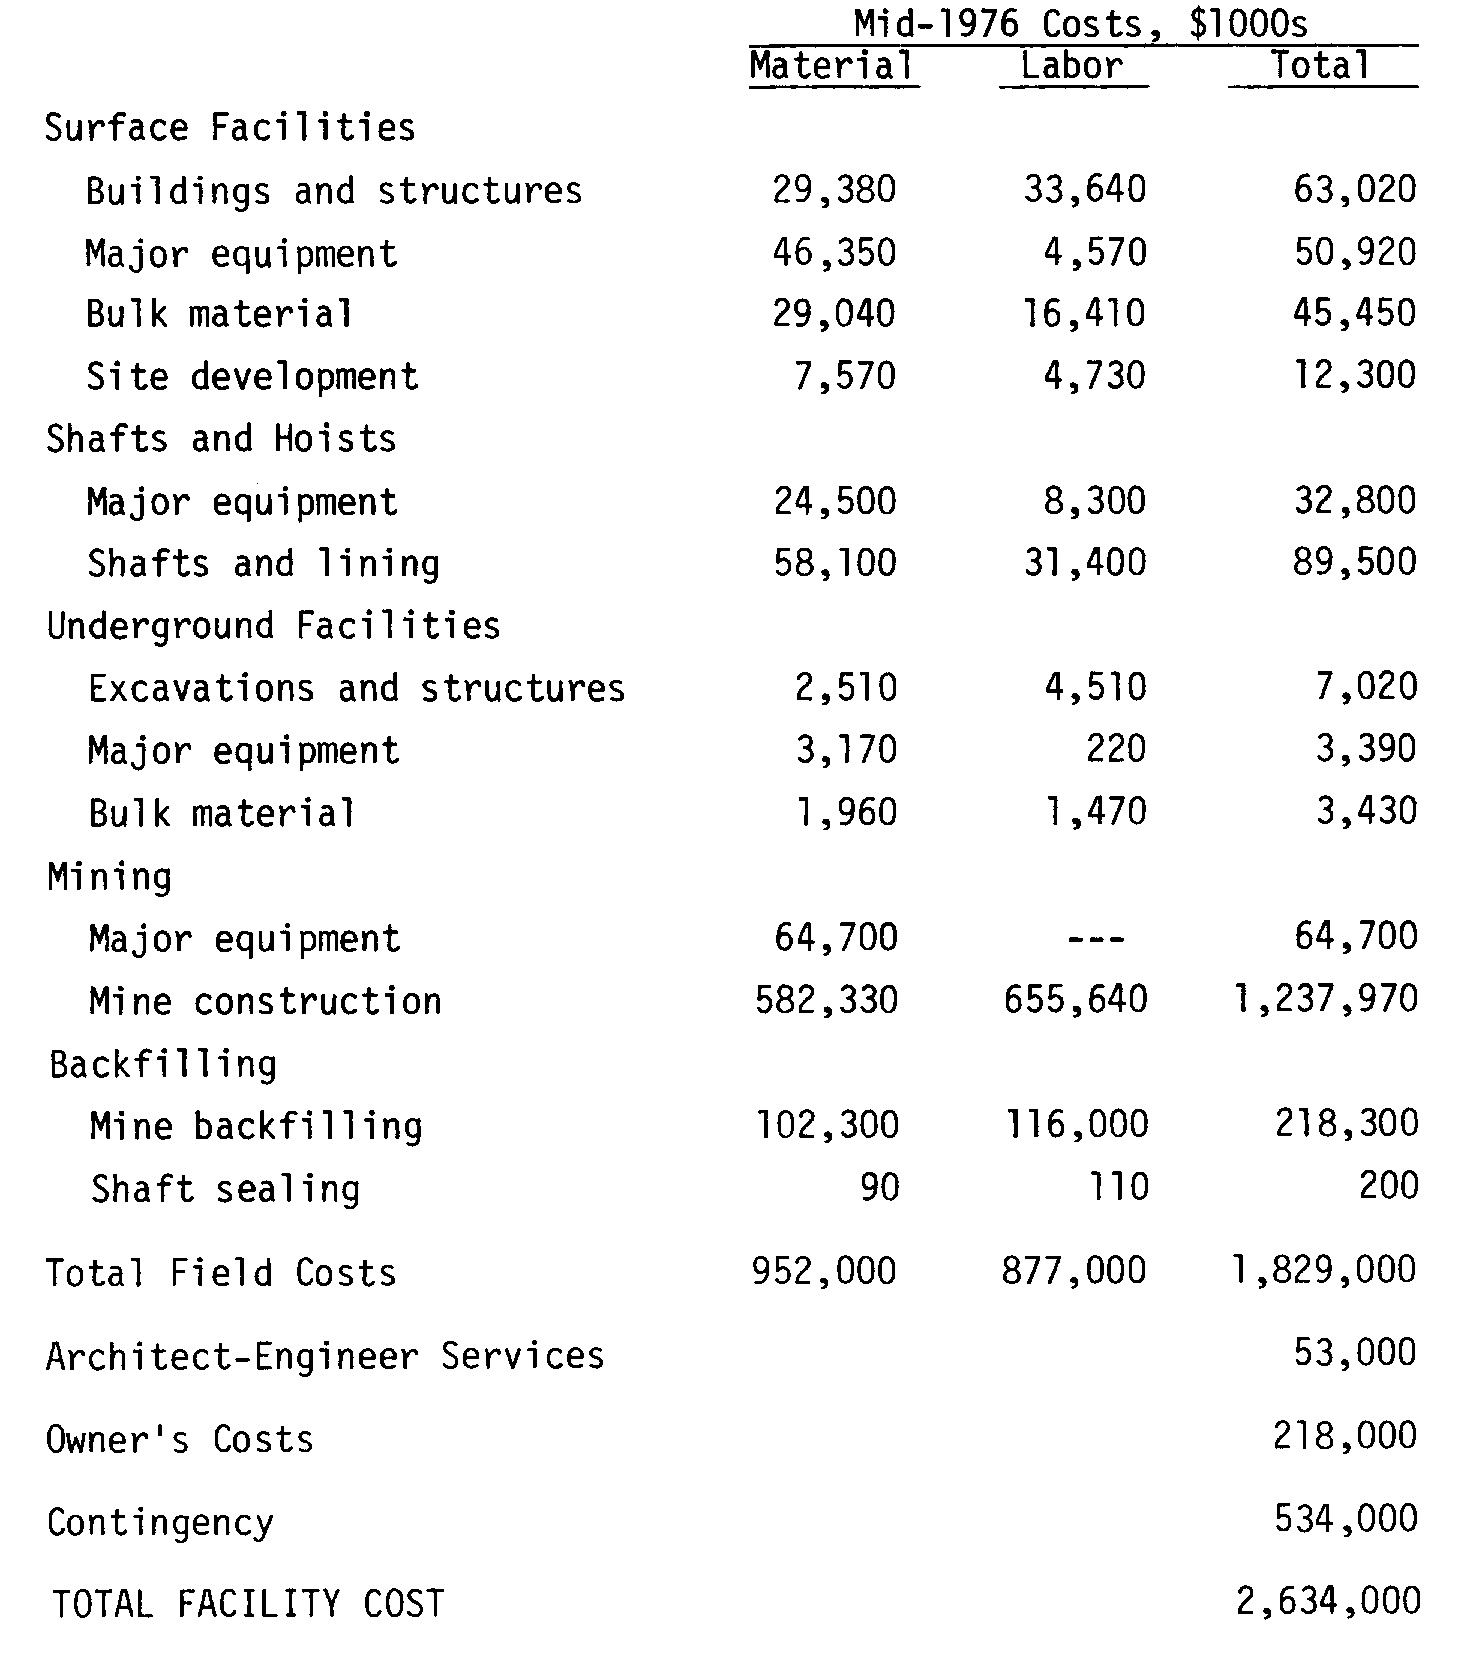


    Image #1:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/tableImage/table2.png
    Resolution: 143 dpi
    Width: 644 px
    Height: 1144 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


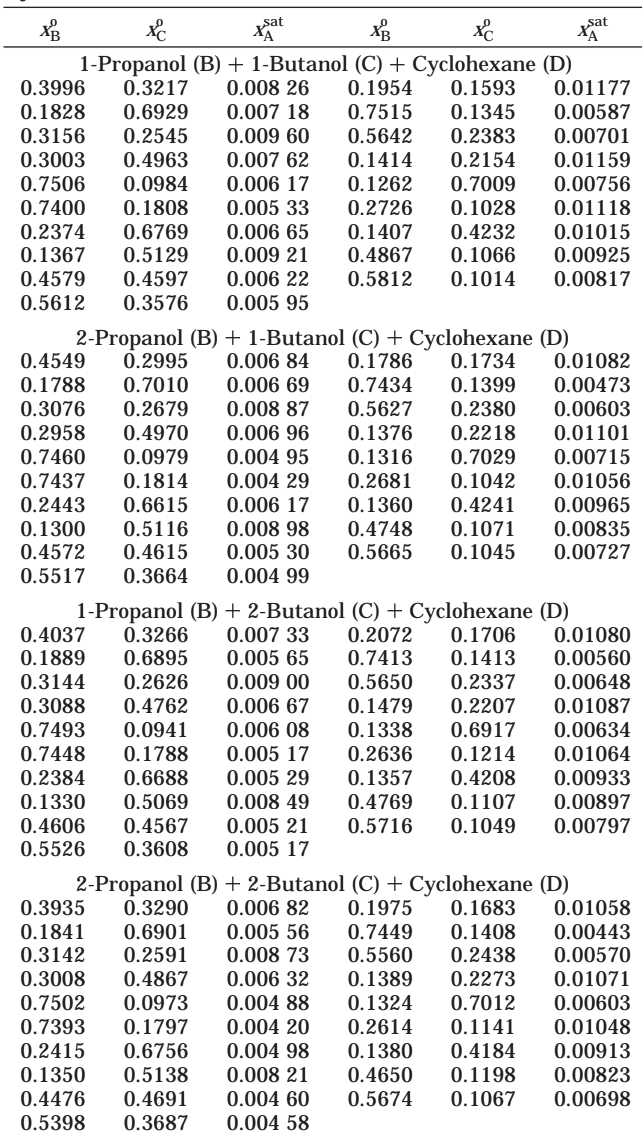


    Image #2:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/tableImage/table0.png
    Resolution: 143 dpi
    Width: 1350 px
    Height: 526 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


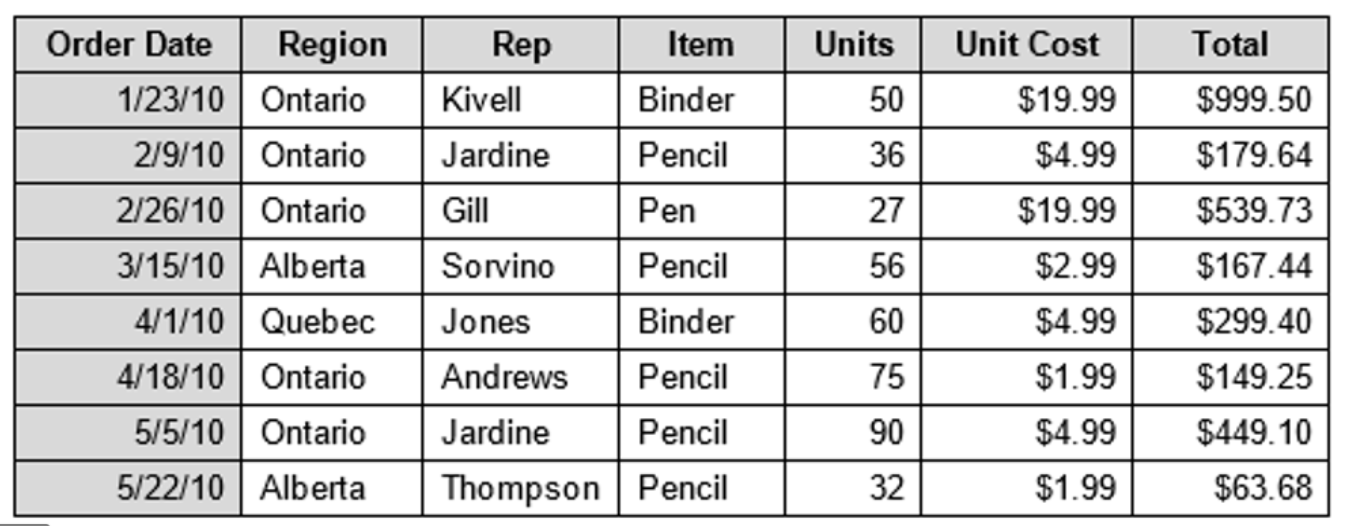

In [14]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images, display_table, display_tables
from pyspark.ml import PipelineModel
import pyspark.sql.functions as f

import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/tableImage/table[0,2,4]*.*')
image_df= spark.read.format("binaryFile").load(test_image_path)

display_images(BinaryToImage().transform(image_df), "image")

**Define OCR Pipeline**

In [15]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_BYTE_GRAY)
binary_to_image.setInputCol("content")

cell_detector = ImageTableCellDetector()
cell_detector.setInputCol("image")
cell_detector.setOutputCol("cells")
cell_detector.setKeepInput(True)
cell_detector.setAlgoType("morphops")
cell_detector.setDrawDetectedLines(True)

table_recognition = ImageCellsToTextTable()
#table_recognition.setInputCol("output_image")
table_recognition.setInputCol("image")
table_recognition.setCellsCol('cells')
table_recognition.setMargin(2)
table_recognition.setStrip(True)
table_recognition.setOutputCol('table')

pipeline = PipelineModel(stages=[
    binary_to_image,
     cell_detector,
     table_recognition
])

**Run Pipeline**

In [16]:
results = pipeline.transform(image_df).cache()

In [17]:
results= results.na.drop(subset=["cells", "output_image", "table"])


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/tableImage/table4.jpg
    Resolution: 0 dpi
    Width: 1471 px
    Height: 1654 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


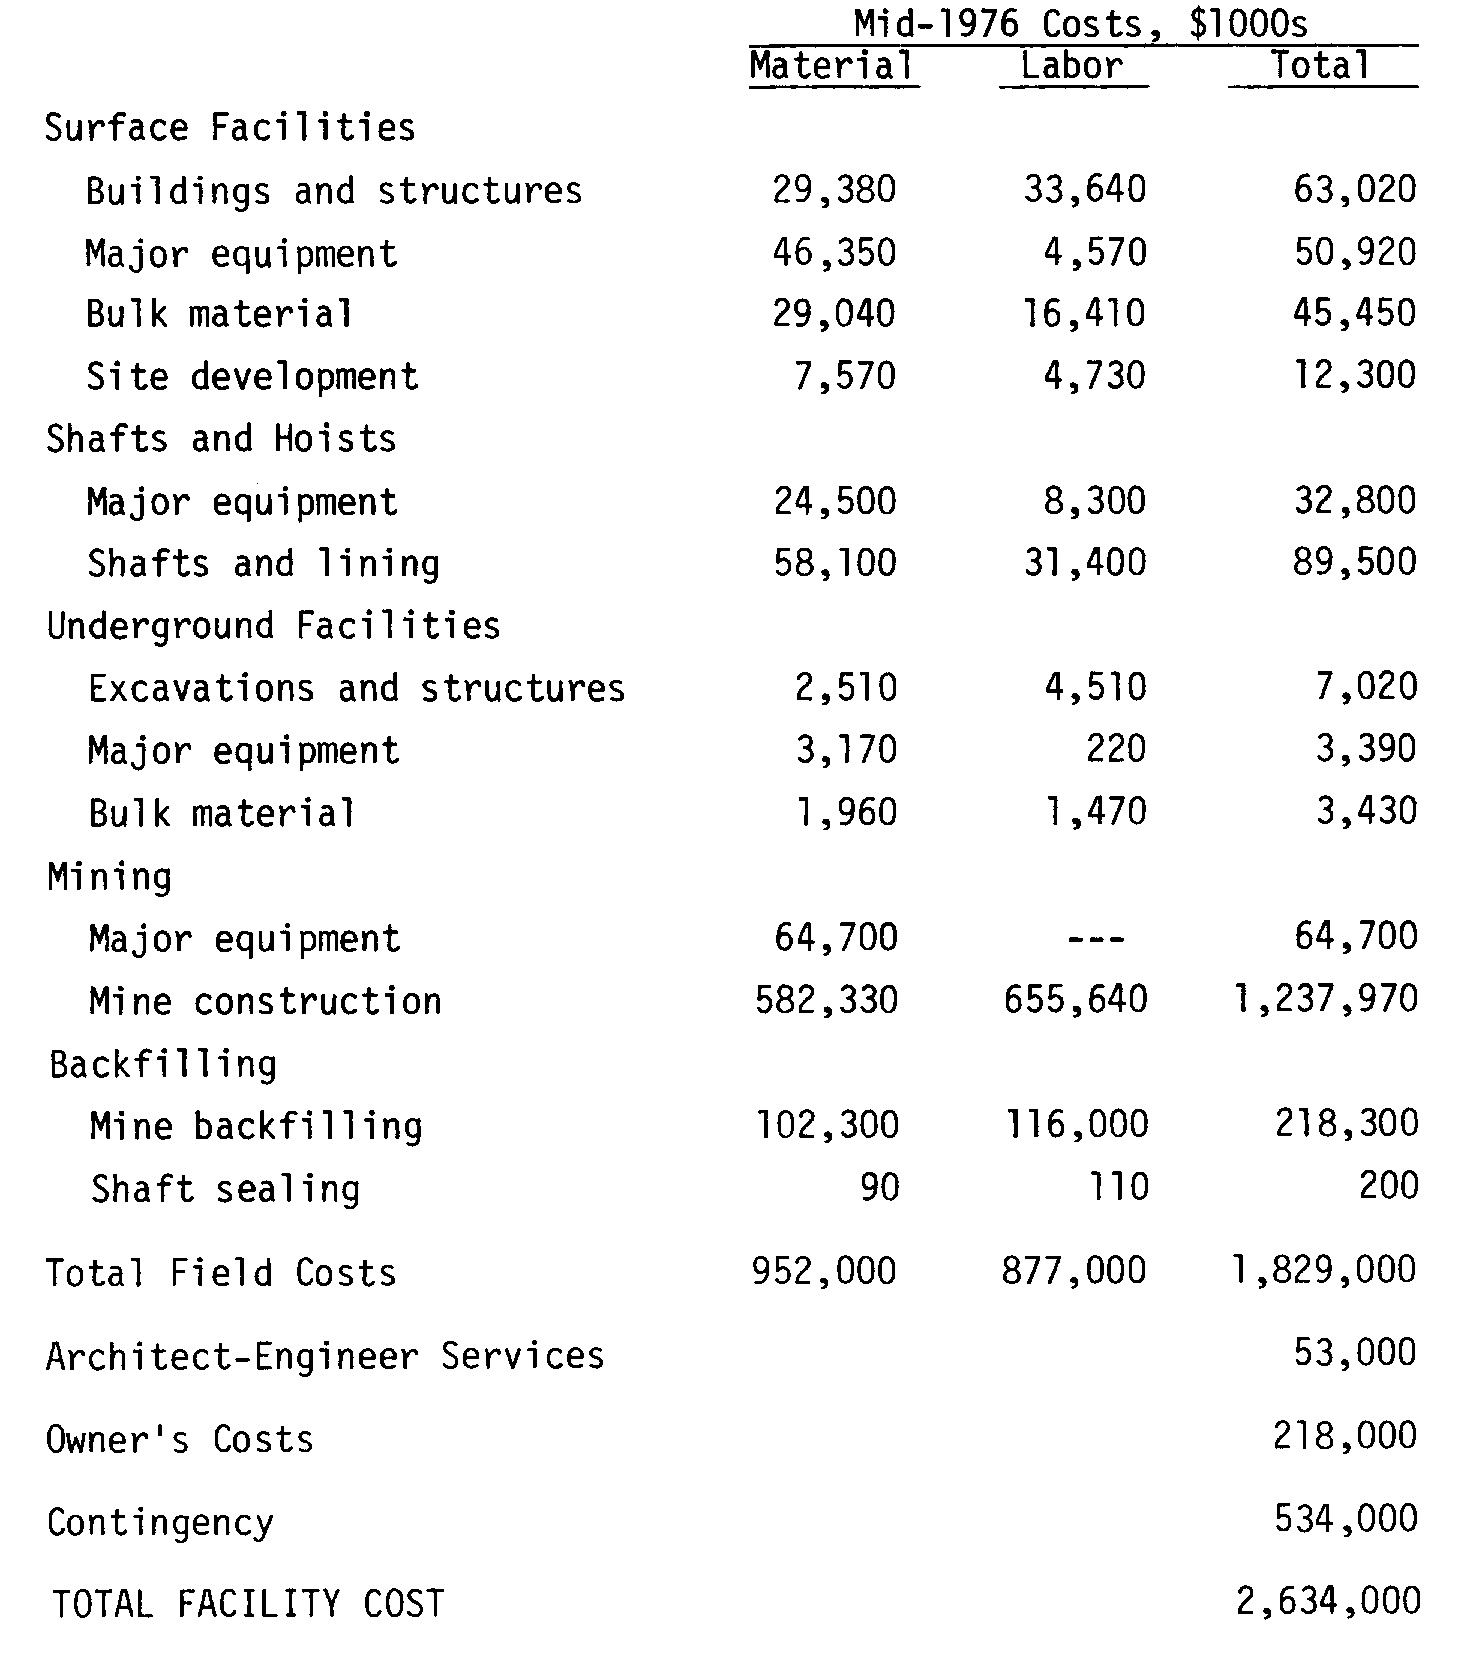


    Image #1:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/tableImage/table0.png
    Resolution: 143 dpi
    Width: 1350 px
    Height: 526 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


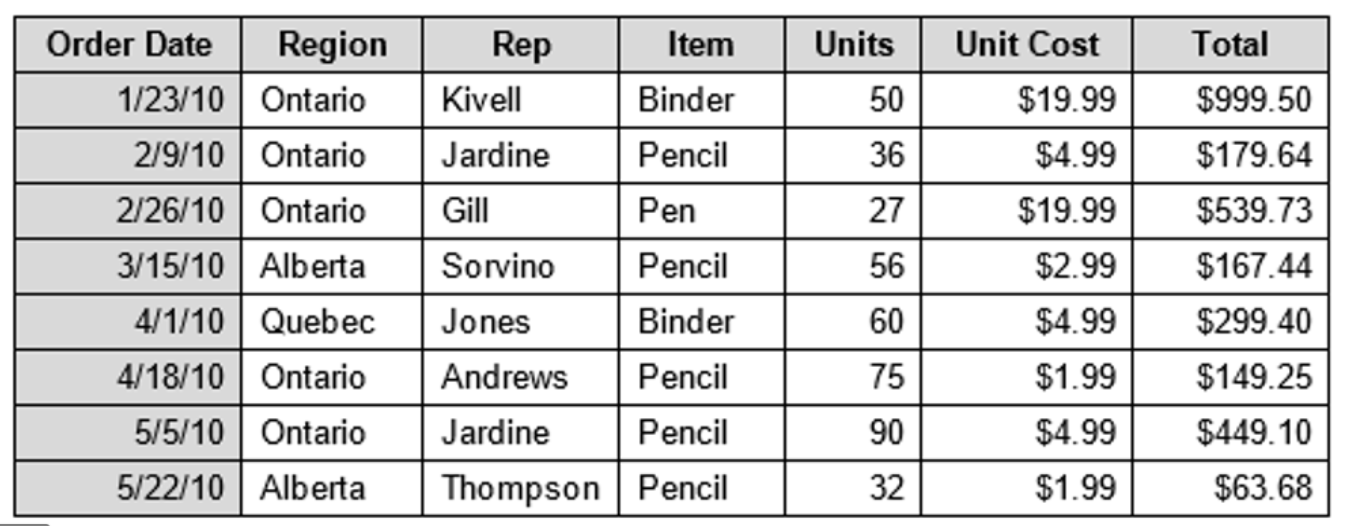

In [18]:
display_images(results, "image")

In [19]:
display_tables(results)

Filename: table0.png
Page:     0
Table:    0


col0     col1      col2      col3  col4       col5     col6
0  Order Date   Region       Rep     Item         Jnit Cost    Total
1     1/23/10  Ontario    Kivell   Binder    60]     $19.99  $999.50
2      2/9/10  Ontario   Jardine    Pencil  36].     $4.99   $179.64
3     2/26/10  Ontario        1G       Pen   a7]     $19.99  $539.73
4     3/15/10  Alberta   Sorvino   Pencil    66]      $2.99  $167.44
5      4/1/10   Quebec     Jones    Binder   60]     $4.99   $299.40
6     4/18/10  Ontario   Andrews    Pencil   75       $1.99  $149.25
7      5/5/10  Ontario   Jardine   Pencil    90]     $4.99]  $449.10
8     5/22/10  Alberta  Thompsor    Pencil   32]      $1.99   $63.68

Filename: table4.jpg
Page:     0
Table:    0


col0      col1          col2       col3
0                                   Mid-]  976 Costs. $      1000s
1                                Material         Labor      Total
2            Surface Facilities                                   
3      Buildings and structures    29,380        33,640     63,020
4               Major equipment   46 ,350         4,570     50,920
5                 Bulk material    29,040        16,410     45,450
6              Site development     7,570         4,730     12,300
7             Shafts and Hoists                                   
8               Major equipment    24,500         8,300    32 ,800
9             Shafts and lining    58,100        31,400     89,500
10       Underground Facilities                                   
11    Excavations and structure   S 2,510         4,510      7,020
12              Major equipment     3,170           220      3,390
13                Bulk material     1,960         1,470      3,430
14                       Mining                                   
15              Major equipment    64,700                   64,700
16            Mine construction  582 ,330       655,640  1,237,970
17                  Backfilling                                   
18             Mine backfilling   102,300       116,000    218,300
19                Shaft sealing        90           110        200
20            Total Field Costs   952,000       877,000  1,829,000
21  Architect-Engineer Services                             53,000
22                Owner's Costs                            218,000
23                  Contingency                            534,000
24          TOTAL FACILITY COST                          2,634,000

**Show recognized cells for first image**

In [20]:
table_recognition_csv = ImageCellsToTextTable()
table_recognition_csv.setInputCol("image")
table_recognition_csv.setCellsCol('cells')
table_recognition_csv.setMargin(2)
table_recognition_csv.setStrip(True)
table_recognition_csv.setOutputCol('table')
table_recognition_csv.setOutputFormat('csv')

pipeline_csv = PipelineModel(stages=[
    binary_to_image,
     cell_detector,
     table_recognition_csv
])

In [21]:
results_csv = pipeline_csv.transform(image_df).cache()
print(results_csv.select("table").collect()[2].table)

Order Date,Region,Rep,Item,,Jnit Cost,Total
1/23/10,Ontario,Kivell,Binder,60],$19.99,$999.50
2/9/10,Ontario,Jardine,Pencil,36].,$4.99,$179.64
2/26/10,Ontario,1G,Pen,a7],$19.99,$539.73
3/15/10,Alberta,Sorvino,Pencil,66],$2.99,$167.44
4/1/10,Quebec,Jones,Binder,60],$4.99,$299.40
4/18/10,Ontario,Andrews,Pencil,75,$1.99,$149.25
5/5/10,Ontario,Jardine,Pencil,90],$4.99],$449.10
5/22/10,Alberta,Thompsor,Pencil,32],$1.99,$63.68



##Handwritten Detection

In [22]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/handwritten/page1.jpeg


    Image #0:
    Origin: file:/content/page1.jpeg
    Resolution: 0 dpi
    Width: 1705 px
    Height: 2203 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


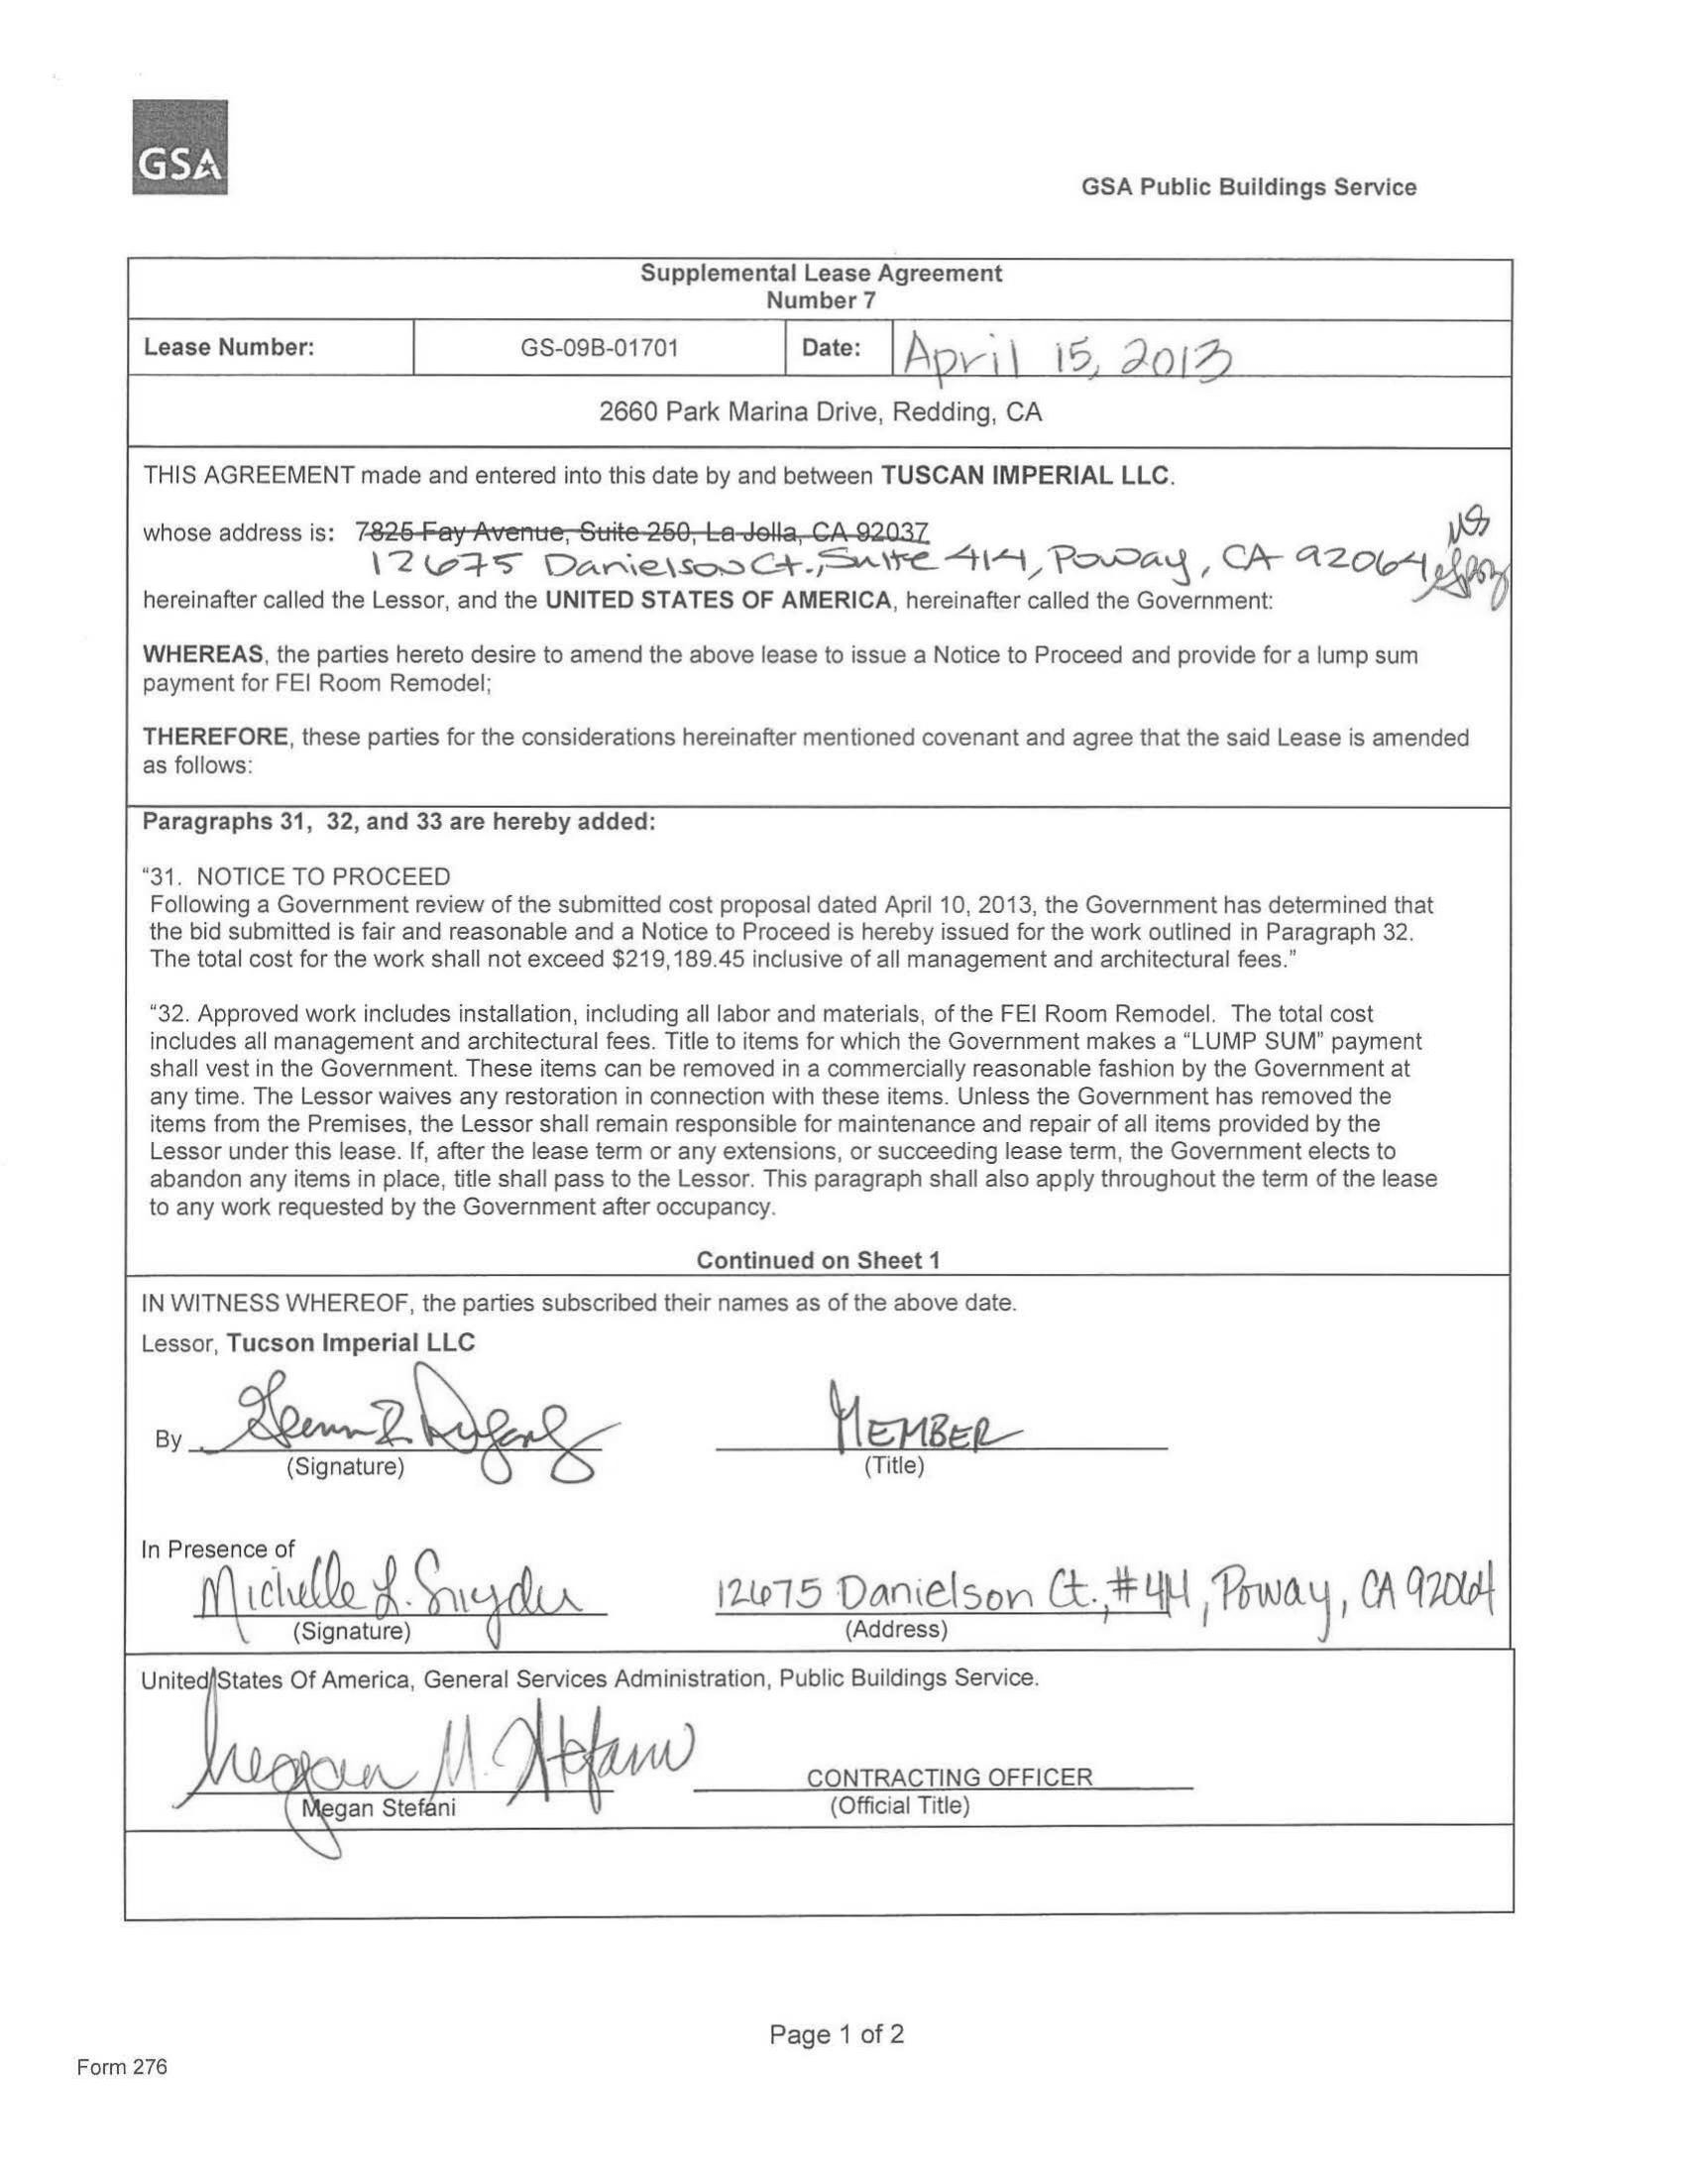

In [23]:
image_df = spark.read.format("binaryFile").load('page1.jpeg')

display_images(BinaryToImage().transform(image_df), "image")

In [24]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0803", "en", "public/ocr/models")

handwritten_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("handwritten_regions") \
    .setScoreThreshold(0.4)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("handwritten_regions") \
    .setOutputCol("image_with_regions") \
    .setFontSize(16) \
    .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    handwritten_detector,
    draw_regions
])

image_handwritten_detector_gsa0803 download started this may take some time.
Approximate size to download 244.5 MB


In [25]:
result =  pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

Output hidden; open in https://colab.research.google.com to view.

##Signature Detection

In [26]:
!wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-ocr-workshop/master/jupyter/data/signature/image_147.png

In [27]:
image_file = 'image_147.png'
image_df = spark.read.format("binaryFile").load(image_file)

display_images(BinaryToImage().transform(image_df), "image")

Output hidden; open in https://colab.research.google.com to view.

**Define OCR Pipeline**

In [28]:
binary_to_image = BinaryToImage()
binary_to_image.setImageType(ImageType.TYPE_3BYTE_BGR)

pretrained_model = ("image_handwritten_detector_gsa0628", "en", "public/ocr/models")
signature_detector = ImageHandwrittenDetector() \
    .pretrained(*pretrained_model) \
    .setInputCol("image") \
    .setOutputCol("signature_regions") \
    .setOutputLabels(["signature"]) \
    .setScoreThreshold(0.4)

draw_regions = ImageDrawRegions() \
    .setInputCol("image") \
    .setInputRegionsCol("signature_regions") \
    .setOutputCol("image_with_regions") \
    .setFontSize(16) \
    .setRectColor(Color.red)

pipeline = PipelineModel(stages=[
    binary_to_image,
    signature_detector,
    draw_regions
])

image_handwritten_detector_gsa0628 download started this may take some time.
Approximate size to download 243.9 MB


**Run pipeline and show results**

In [29]:
result =  pipeline.transform(image_df).cache()
display_images(result, "image_with_regions")

Output hidden; open in https://colab.research.google.com to view.

## Visual Document Ner

In [30]:
from sparkocr.transformers import ImageToHocr, VisualDocumentNer, BinaryToImage
from sparkocr.utils import display_images, display_image

In [31]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/SROIE/')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+-------+--------------------+
|                path|    modificationTime| length|             content|
+--------------------+--------------------+-------+--------------------+
|file:/usr/local/l...|2022-12-23 14:59:...|3378240|[FF D8 FF E0 00 1...|
+--------------------+--------------------+-------+--------------------+




    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/images/SROIE/a05023.jpeg
    Resolution: 0 dpi
    Width: 4961 px
    Height: 7016 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


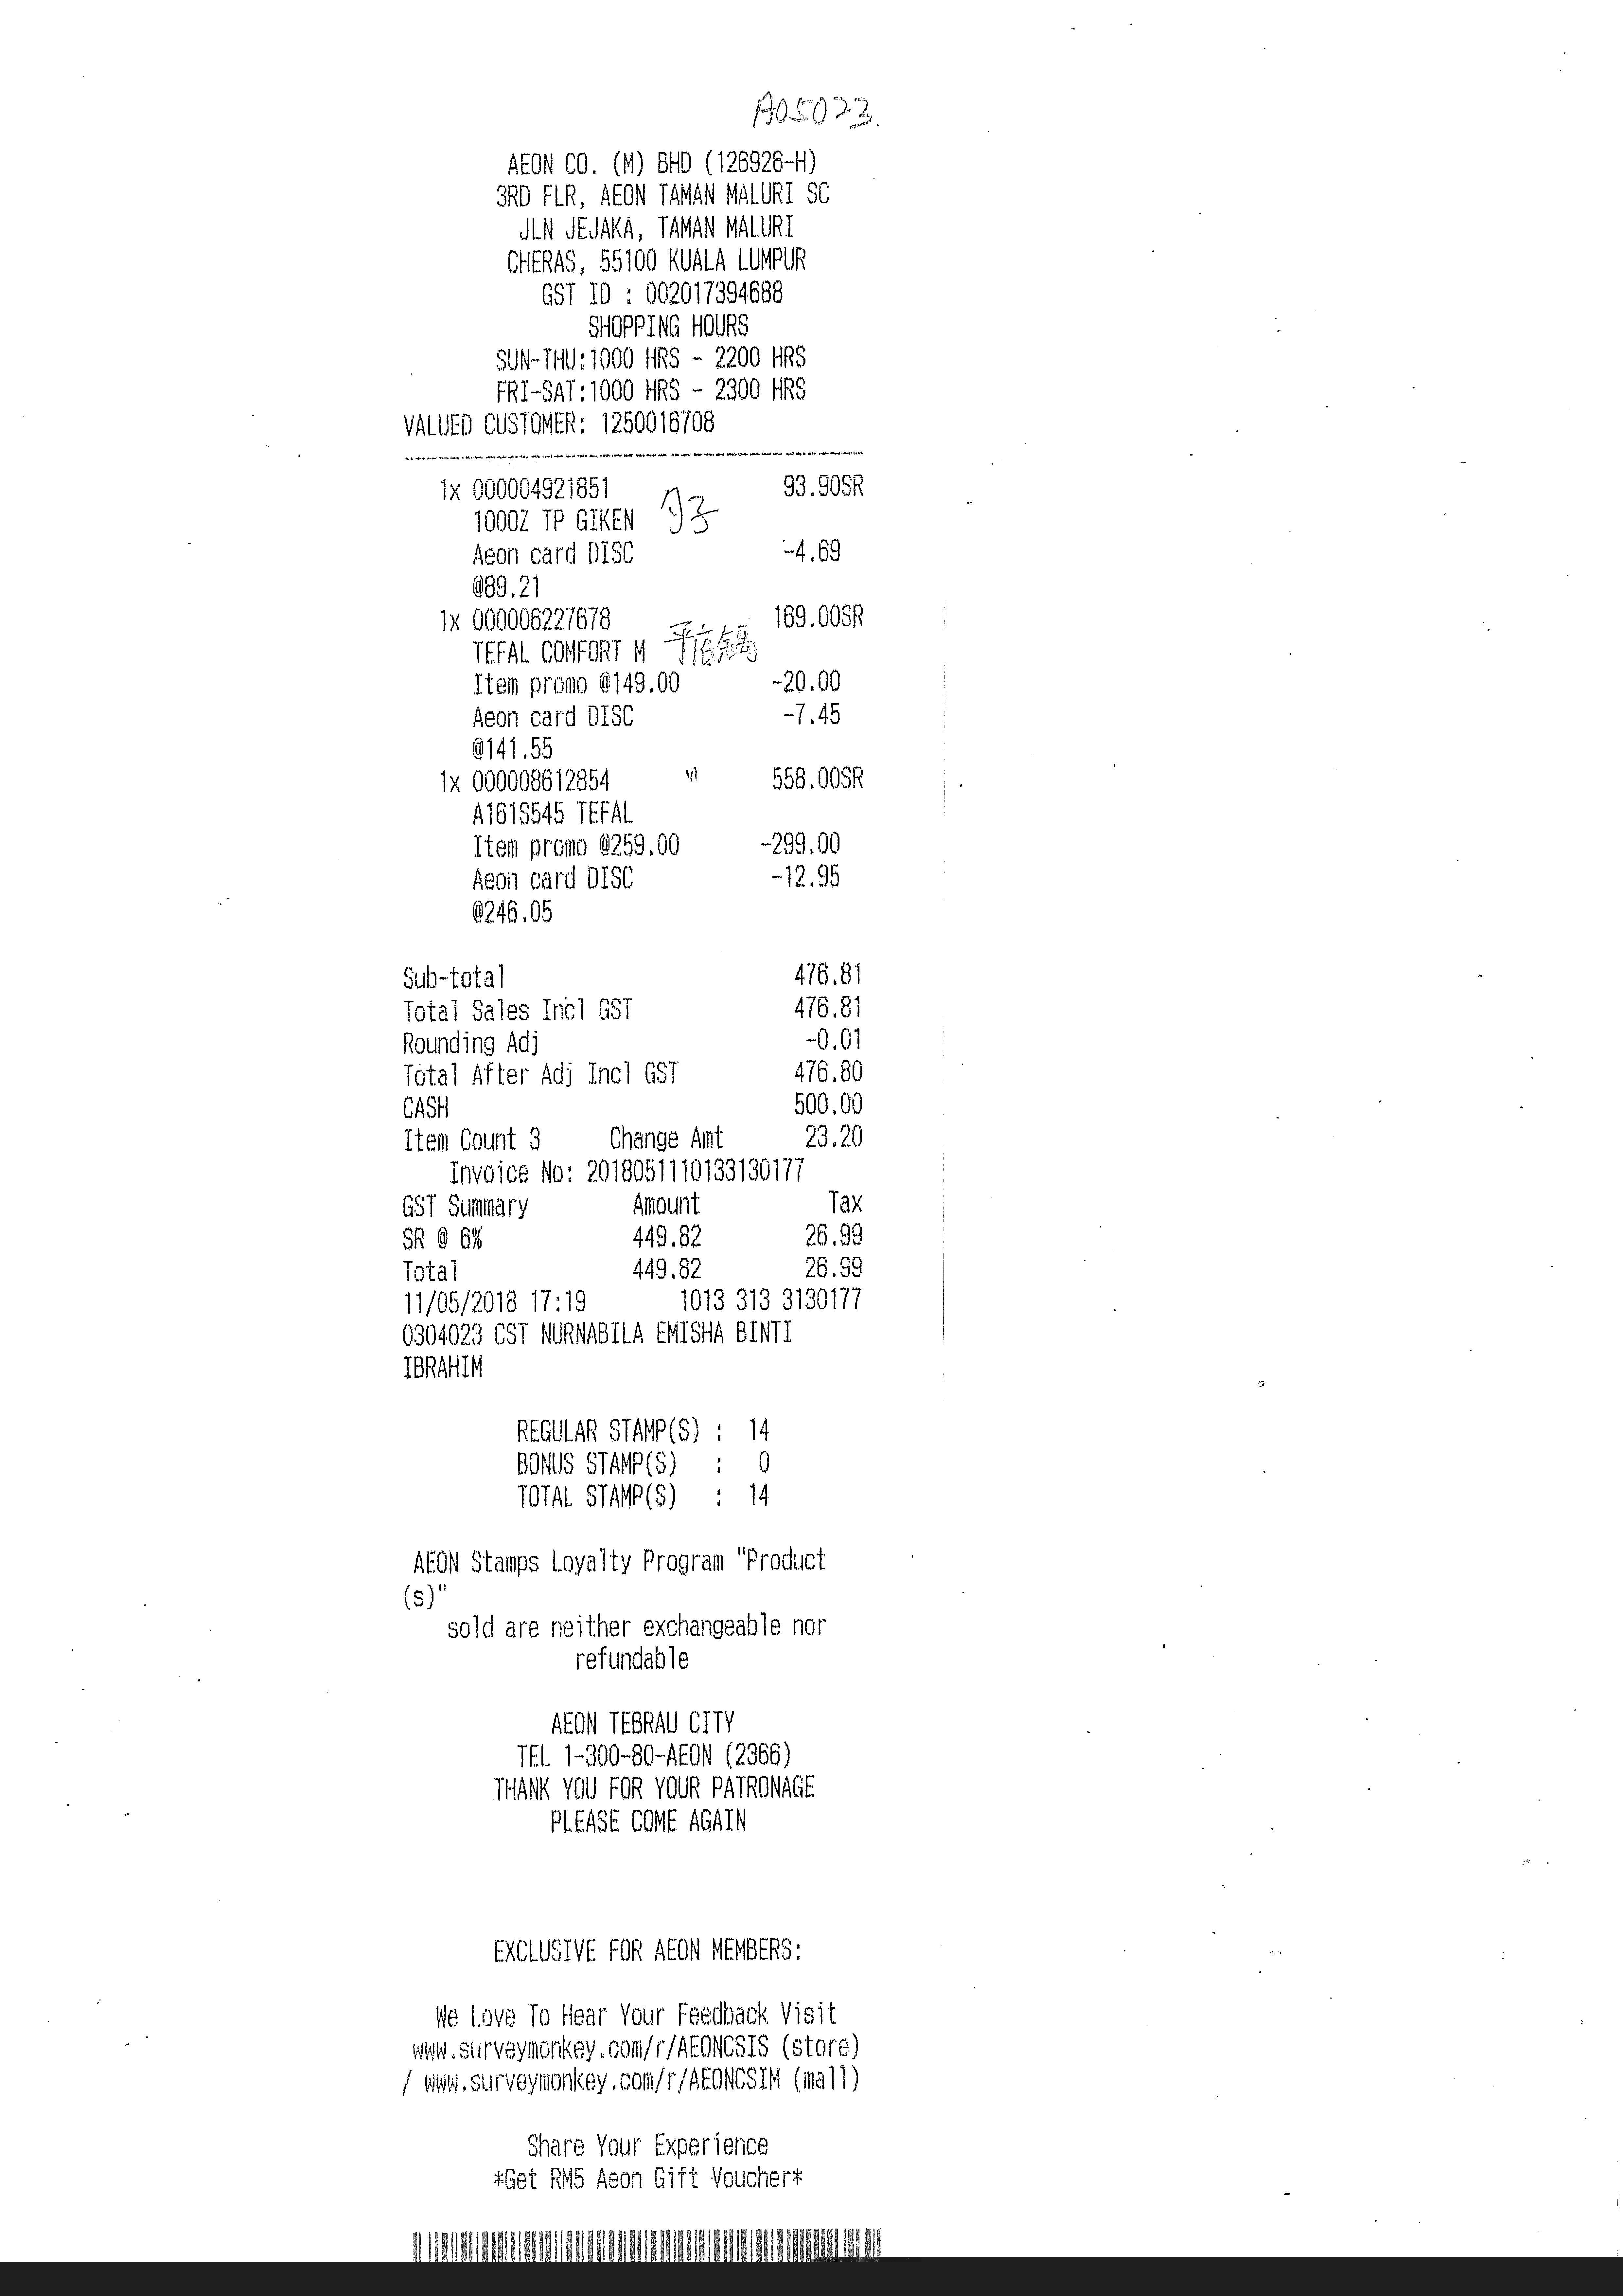

In [32]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

In [33]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image")

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

doc_ner = VisualDocumentNer()\
    .pretrained("visual_document_NER_SROIE0526", "en", "public/ocr/models")\
    .setInputCol("hocr")    

# OCR pipeline
ner_pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_ner
])

visual_document_NER_SROIE0526 download started this may take some time.
Approximate size to download 396 MB


In [34]:
results = ner_pipeline.transform(bin_df).cache()

In [35]:
pd_df = results.select('entities').toPandas().explode('entities')

pd_df['label'] = pd_df.entities.apply(lambda a : a[3])
pd_df['chunk'] = pd_df.entities.apply(lambda a : a[4]['word'])
pd_df[pd_df['label'] != "O"][['label', 'chunk']].drop_duplicates()

label       chunk
0  B-COMPANY        AEON
0  B-COMPANY         CO.
0  B-COMPANY       TAMAN
0    B-TOTAL      476,81
0    B-TOTAL      476.81
0     B-DATE  11/05/2018
0  B-COMPANY         RM5
0  B-COMPANY        Aeon

## Visual Document NER v2

In [36]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/usr/local/l...|2022-12-23 14:59:...|421333|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


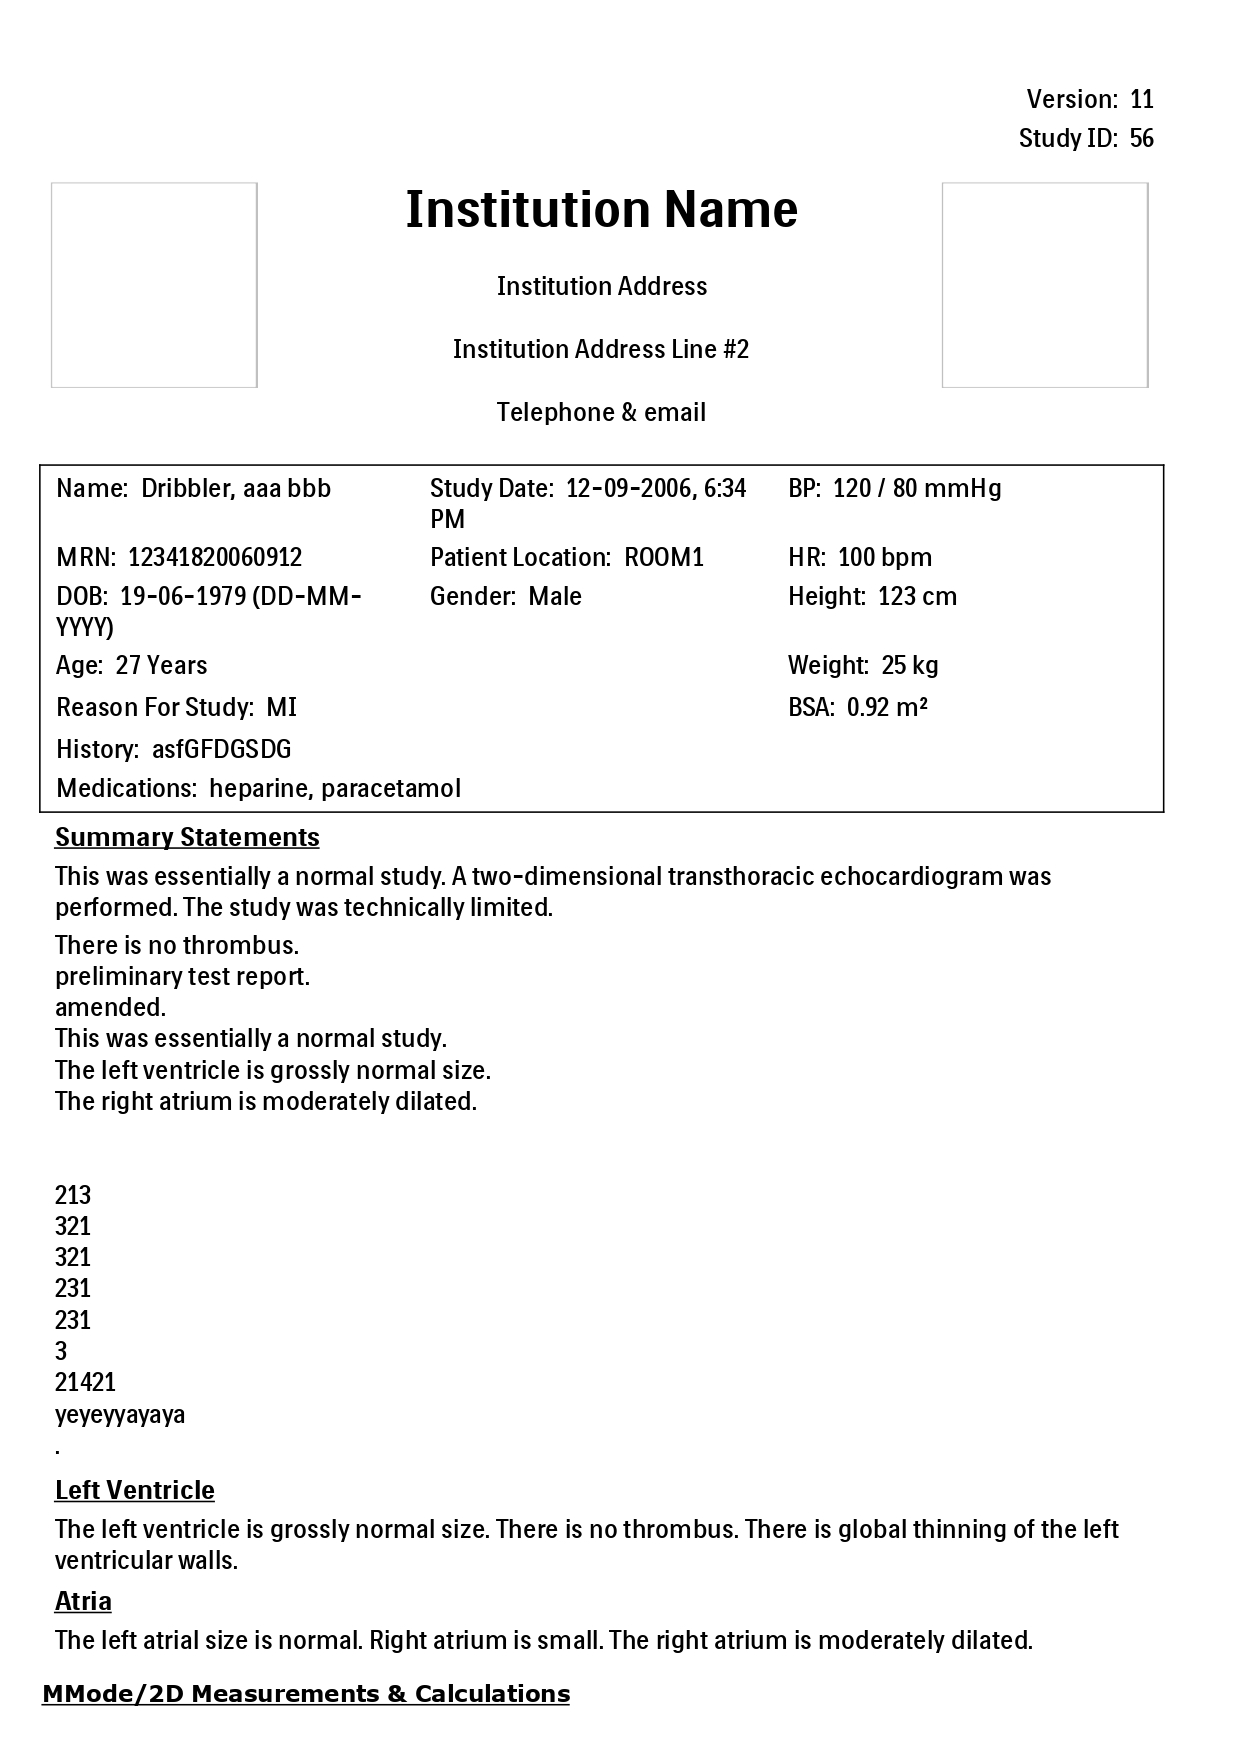

In [37]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)

In [38]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner = VisualDocumentNerV2()\
    .pretrained("layoutlmv2_funsd", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)

# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner,
    draw
])

results = pipeline.transform(bin_df).cache()

In [39]:
pd_df = results.select('entities').toPandas().explode('entities')

pd_df['label'] = pd_df.entities.apply(lambda a : a[3])
pd_df['chunk'] = pd_df.entities.apply(lambda a : a[4]['word'])
pd_result = pd_df[pd_df['label'] != "O"][['label', 'chunk']].drop_duplicates()

In [40]:
pd_result

label         chunk
0   b-question      Version:
0     b-answer            11
0   b-question         Study
0   b-question           ID:
0     b-answer            56
..         ...           ...
0     b-answer      MMode/2D
0     i-answer      MMode/2D
0     i-answer  Measurements
0     i-answer             &
0     i-answer  Calculations

[135 rows x 2 columns]


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


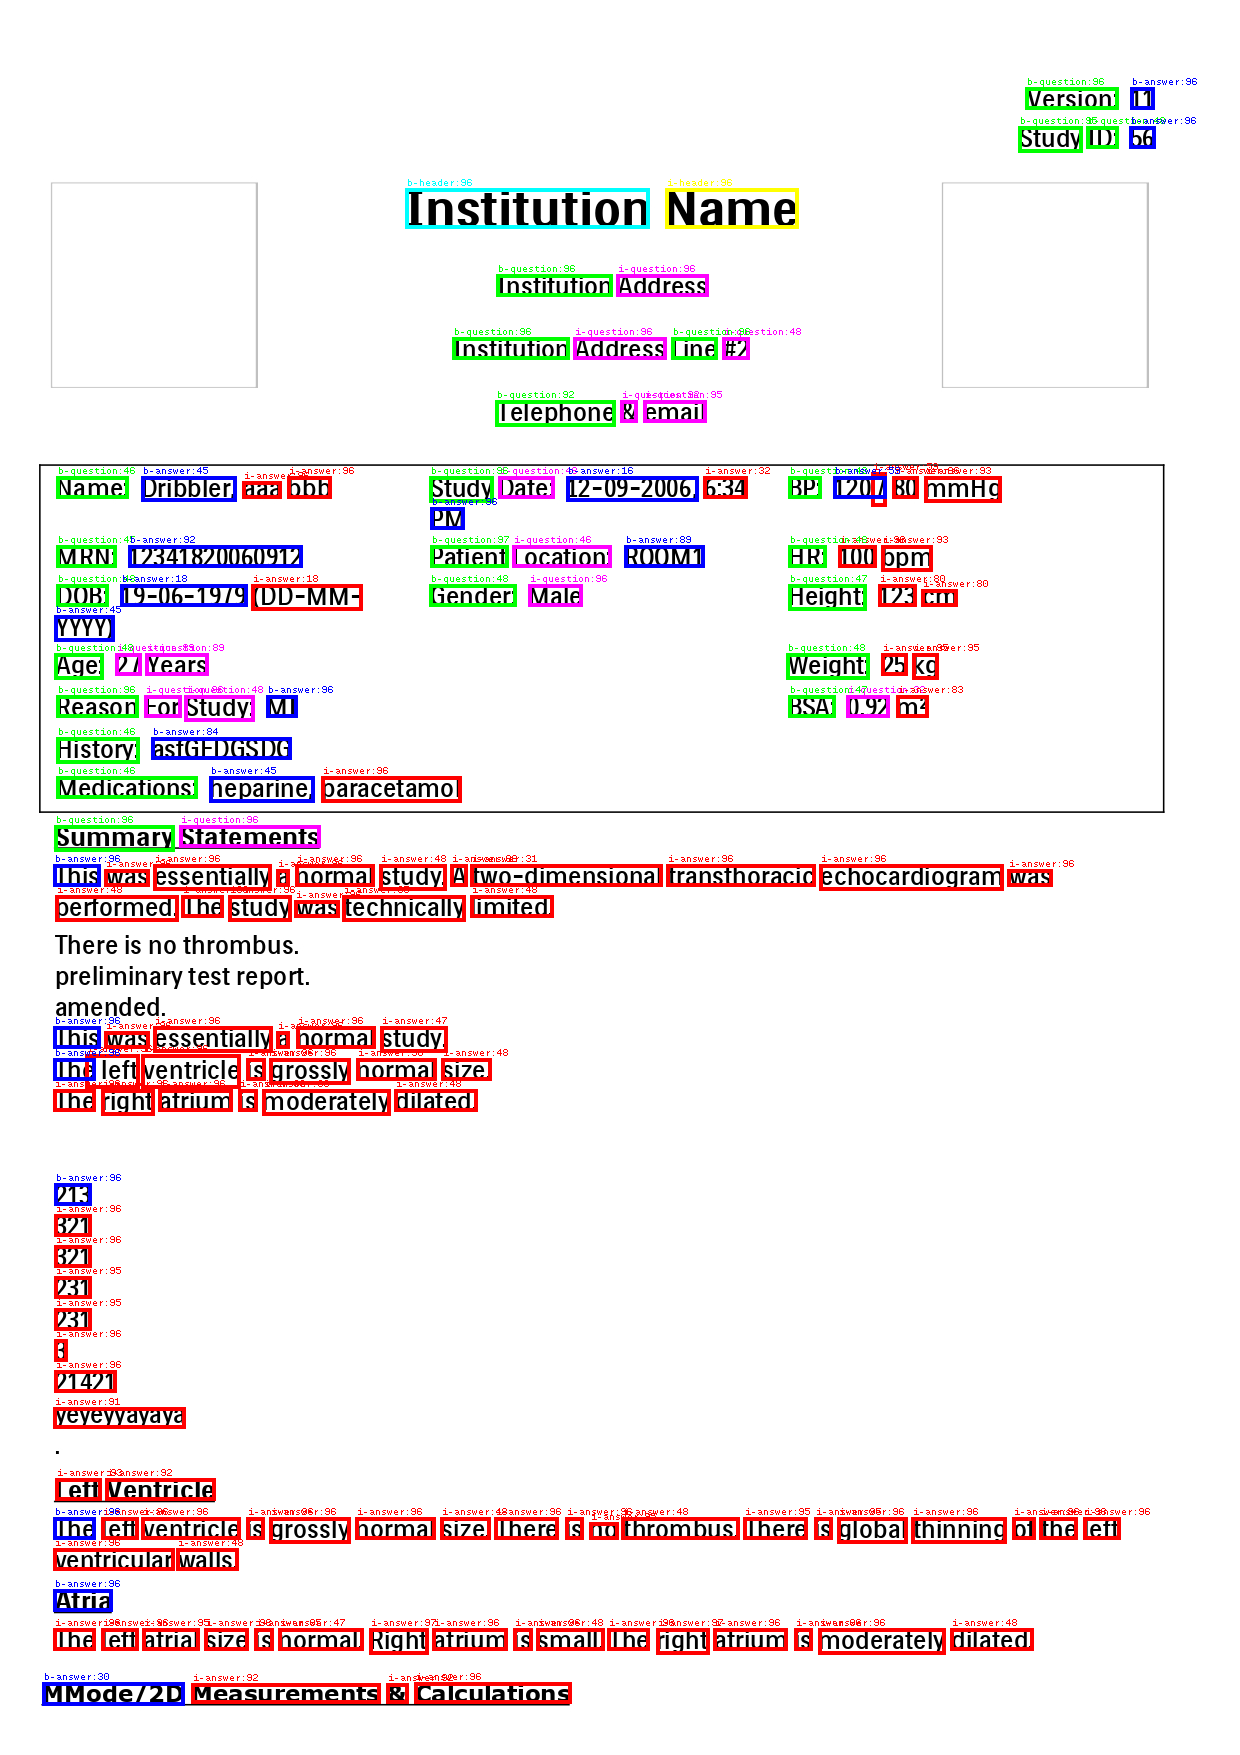

In [41]:
display_images(results, "image_with_annotations", width=1000)

## Visual Document Classifier

In [42]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/images/document_classification/')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/usr/local/l...|2022-12-23 14:59:...|429583|[FF D8 FF E0 00 1...|
|file:/usr/local/l...|2022-12-23 14:59:...|412534|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/images/document_classification/letter.jpg
    Resolution: 72 dpi
    Width: 2400 px
    Height: 3150 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


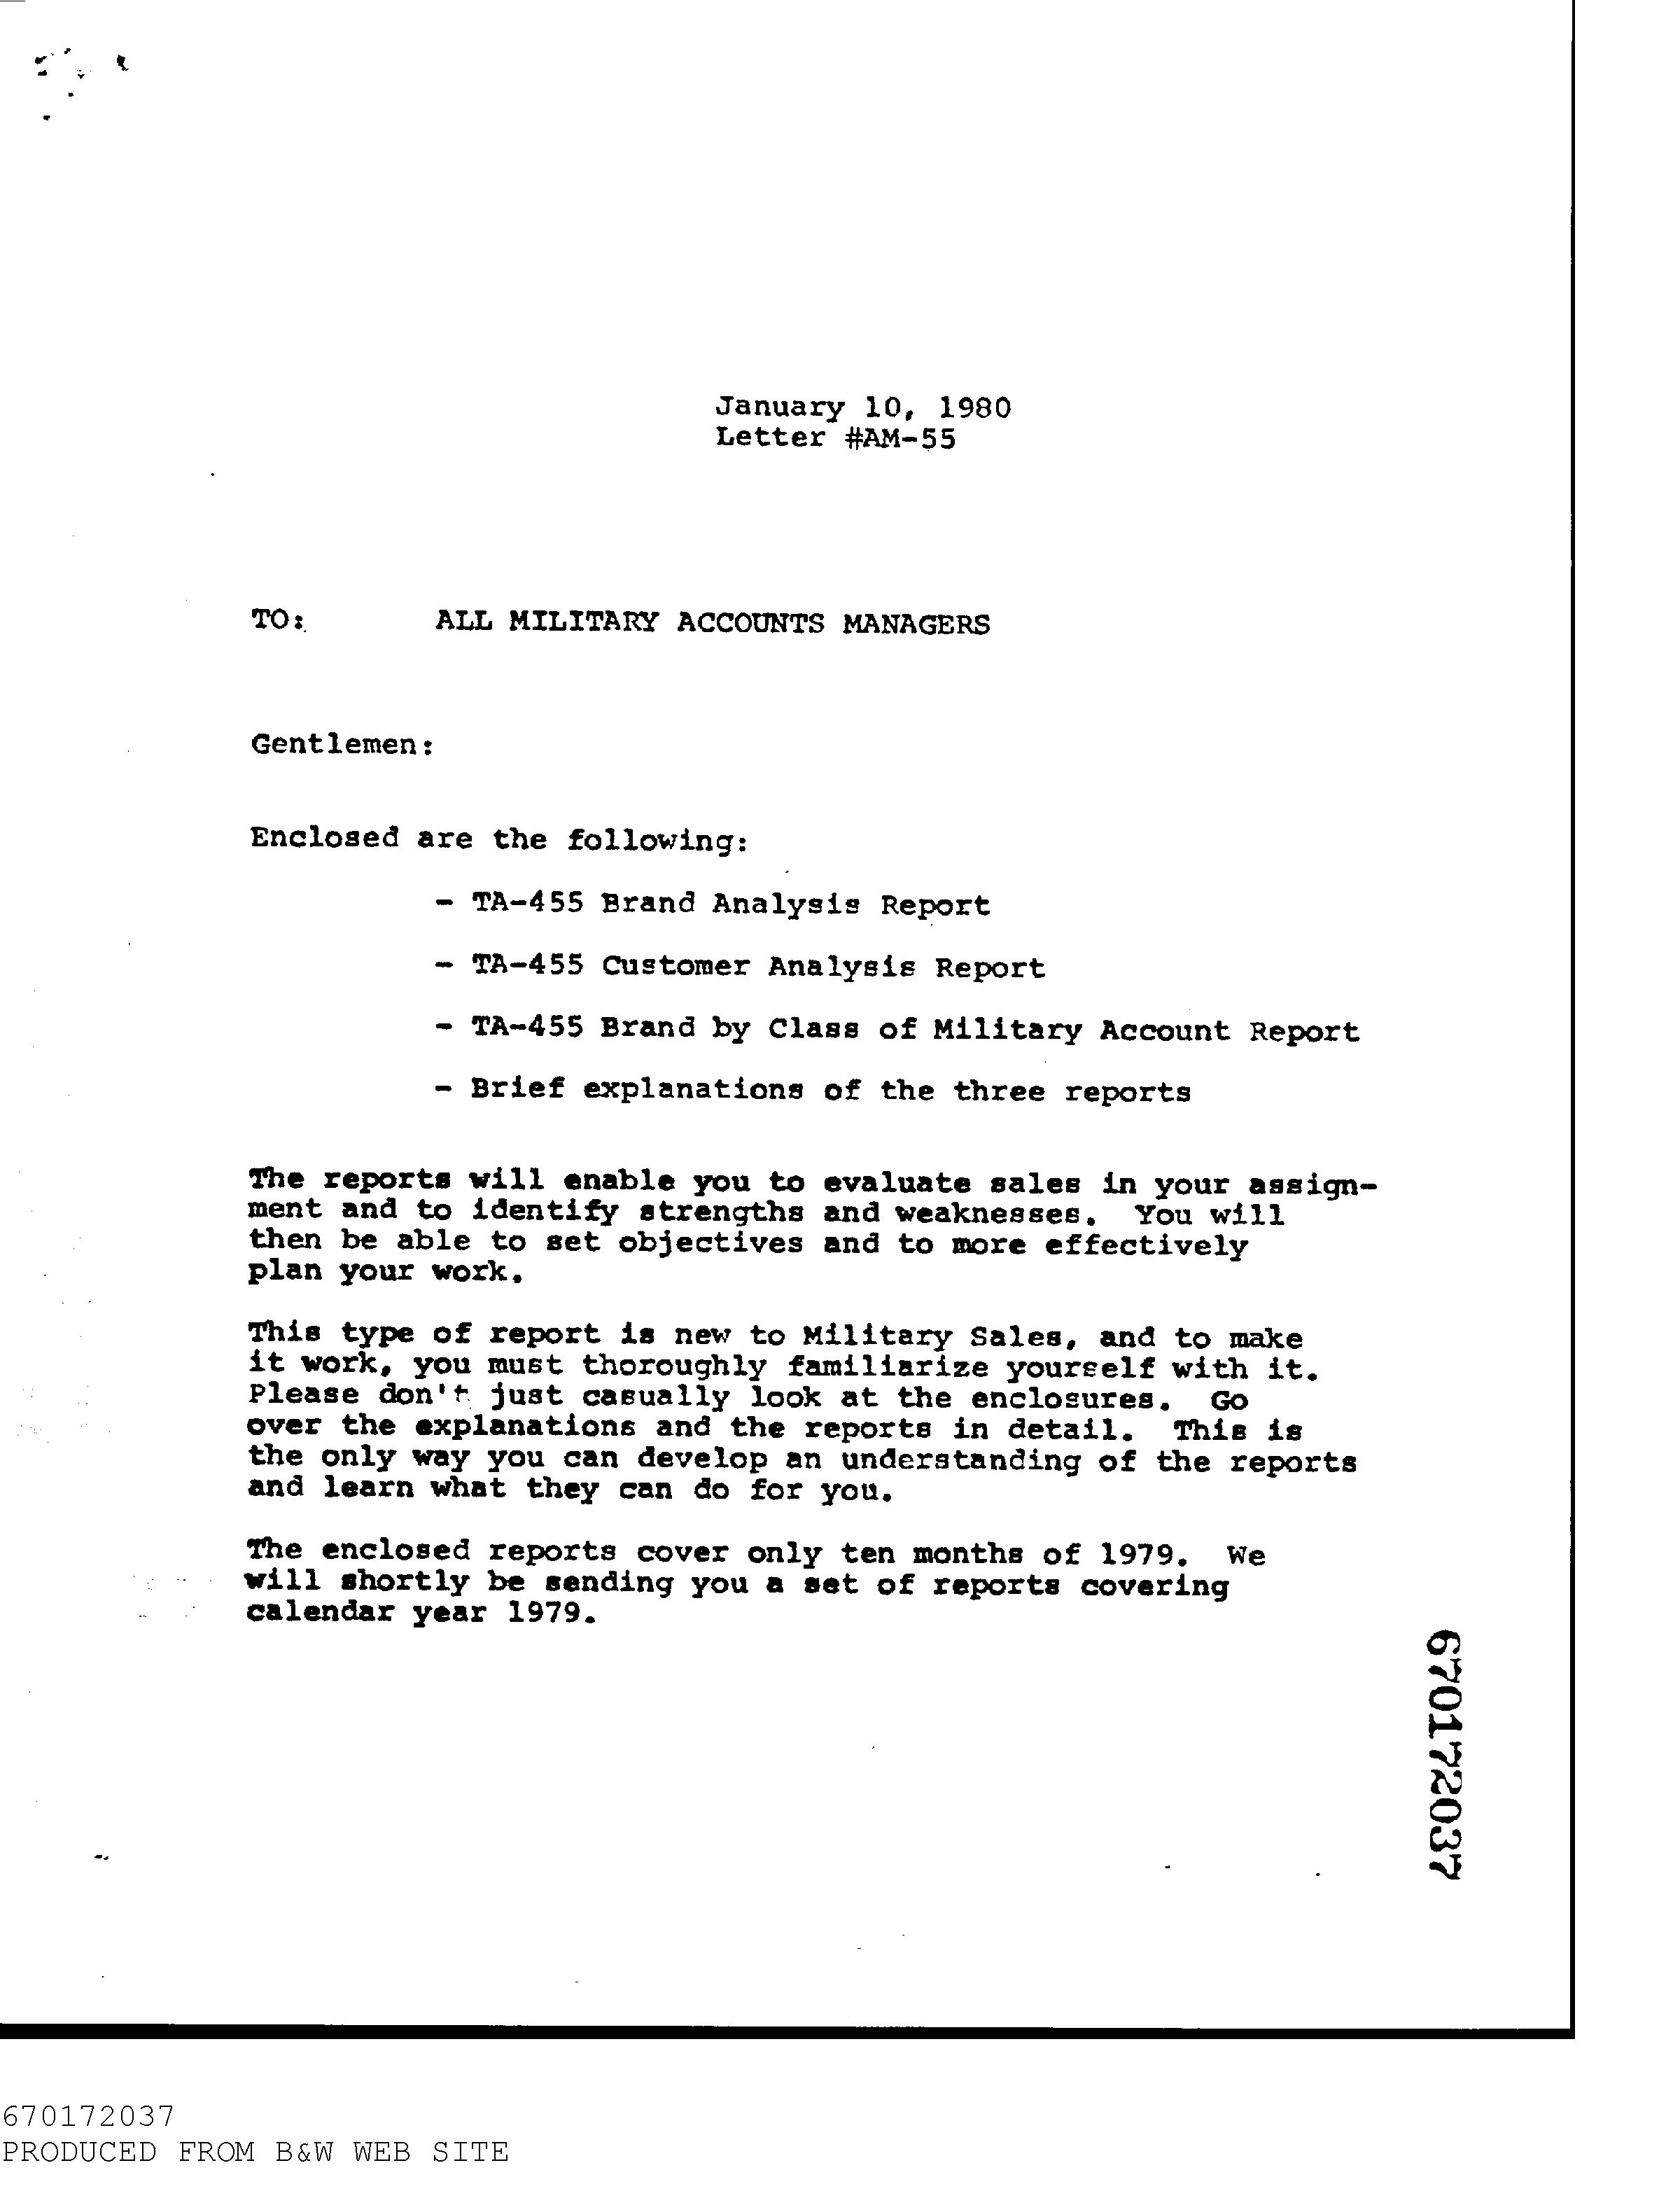


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/images/document_classification/samplecv.jpg
    Resolution: 72 dpi
    Width: 2544 px
    Height: 3296 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


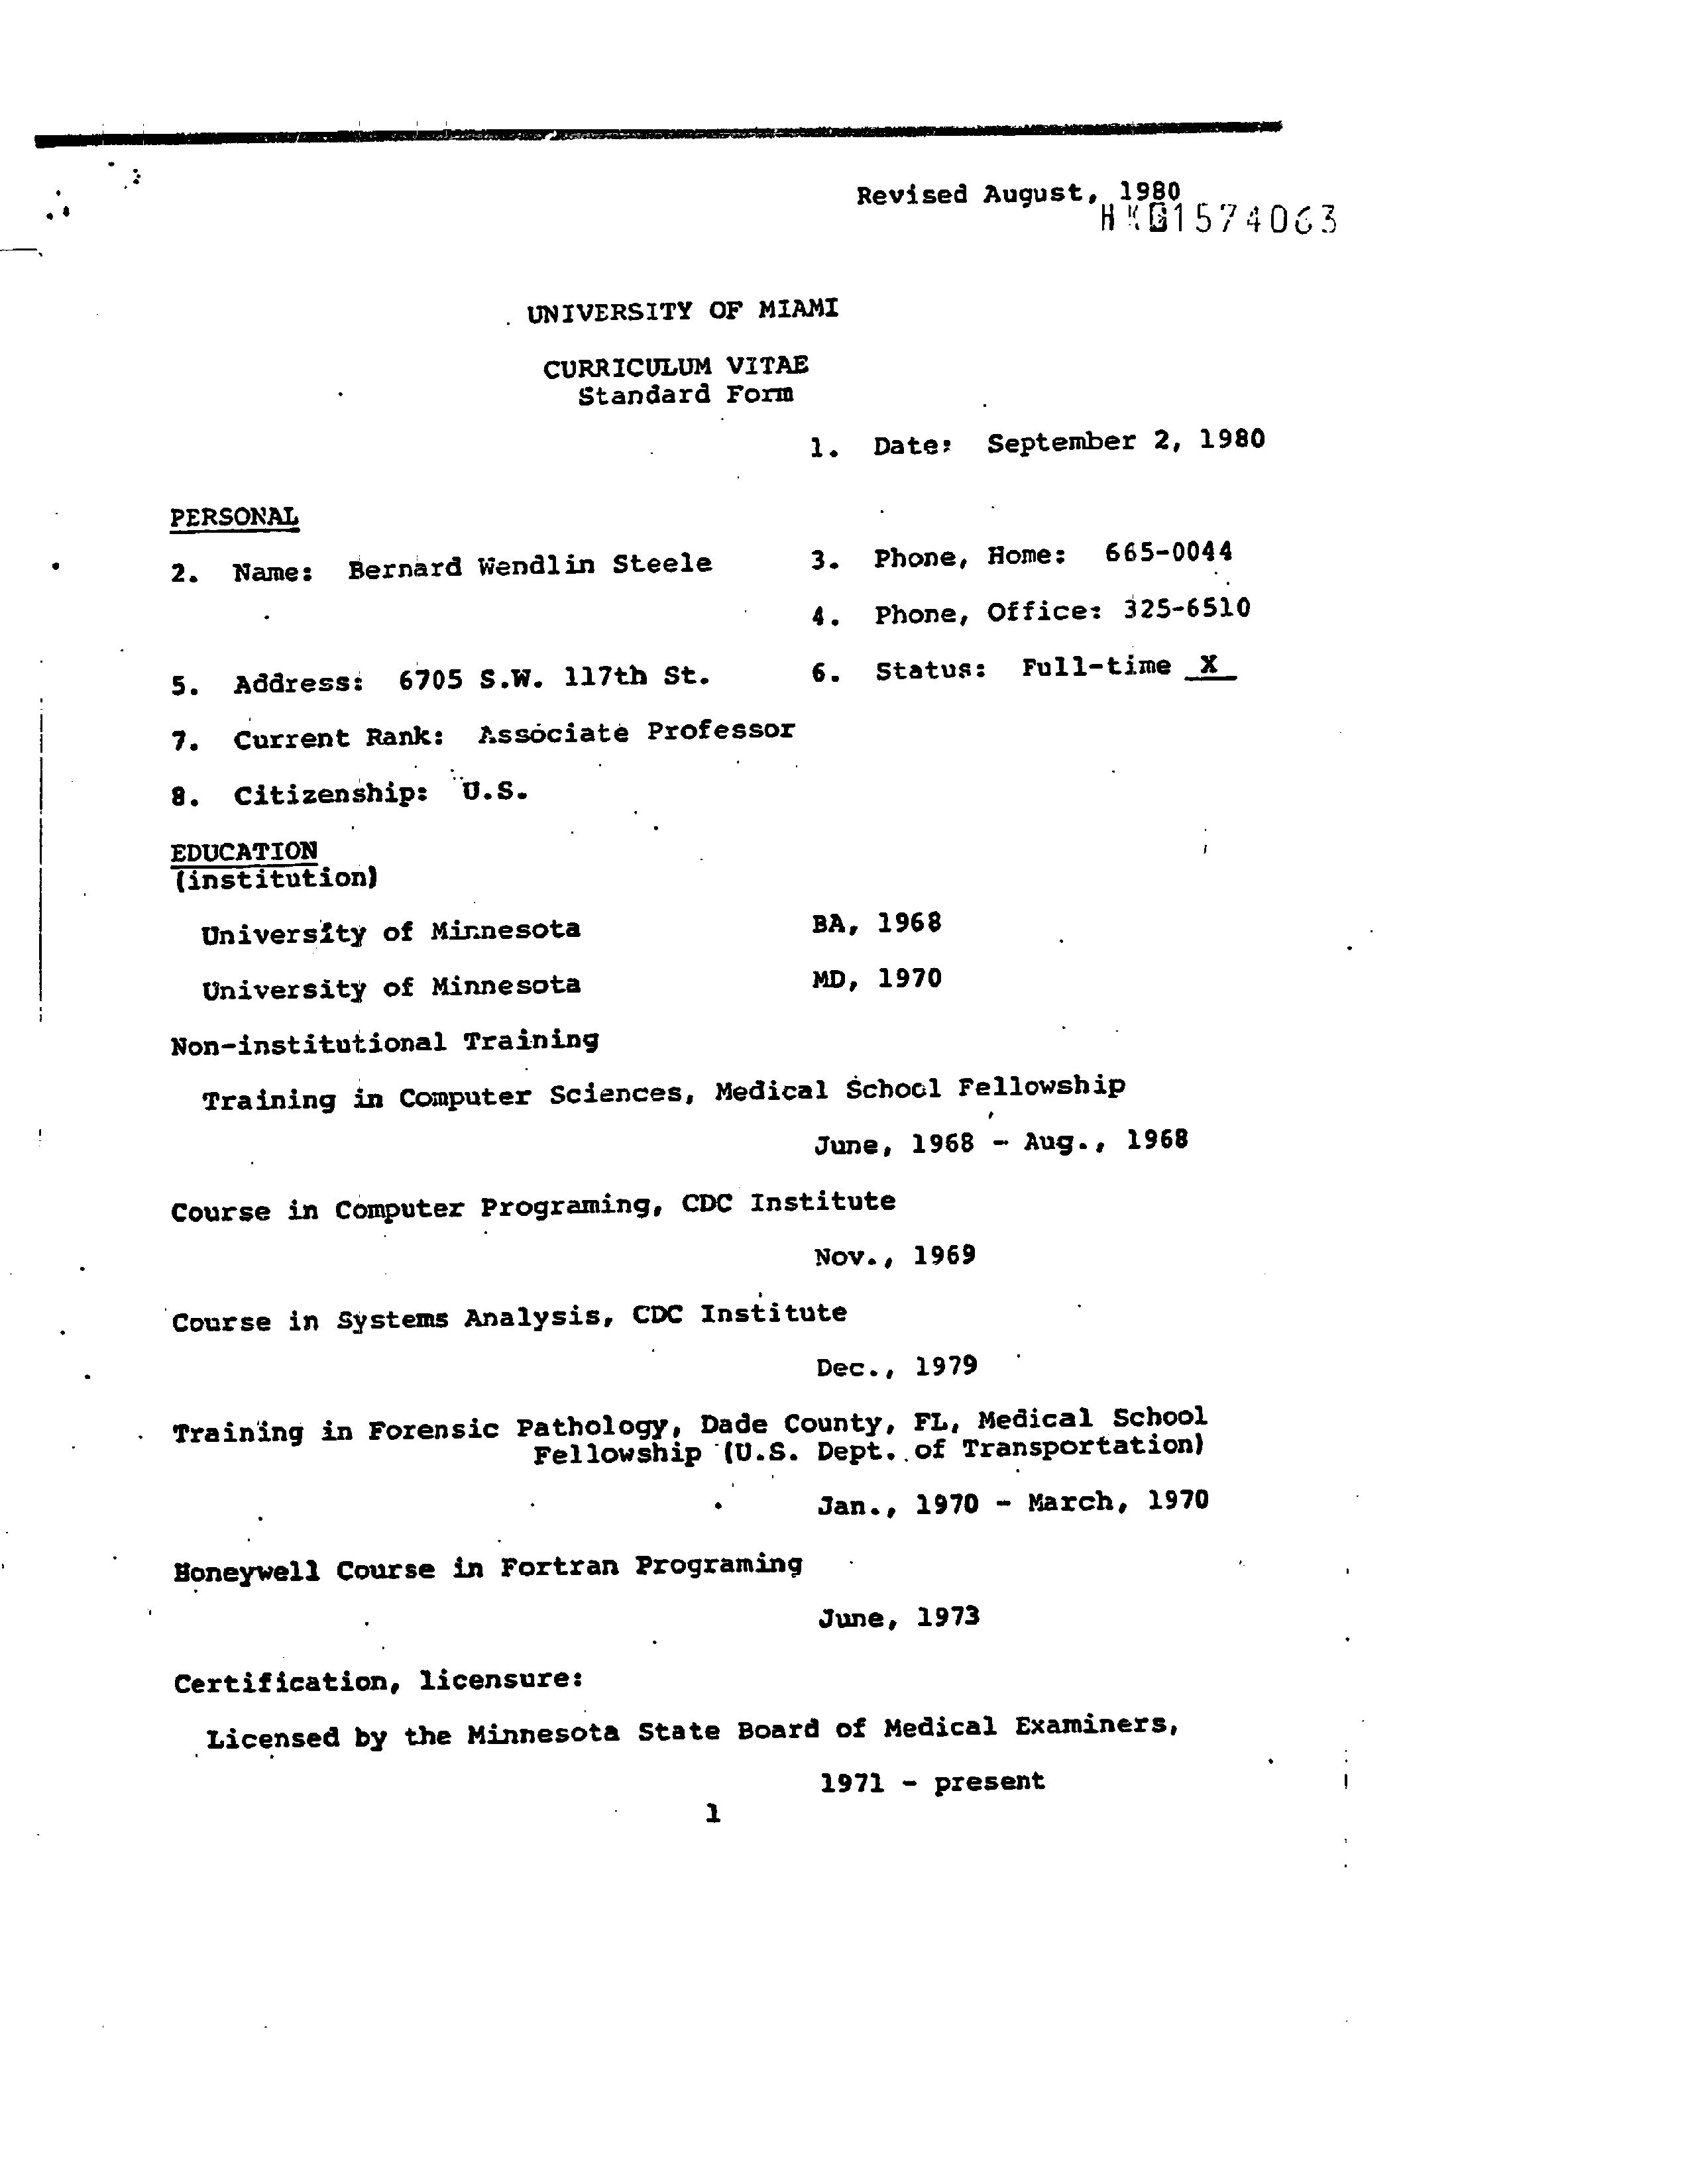

In [43]:
for item in BinaryToImage().transform(bin_df).select("image").collect():
    display_image(item.image)

In [44]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image")

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

doc_classifier = VisualDocumentClassifier()\
    .pretrained("visual_document_classifier_tobacco3482", "en", "clinical/ocr")\
    .setInputCol("hocr")\
    .setLabelCol("label")\
    .setConfidenceCol("conf")

# OCR pipeline
classifier_pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    doc_classifier
])

visual_document_classifier_tobacco3482 download started this may take some time.
Approximate size to download 398.1 MB


In [45]:
results = classifier_pipeline.transform(bin_df)

In [46]:
import pyspark.sql.functions as f

path_array = f.split(results['path'], '/')
results = results.withColumn('filename', path_array.getItem(f.size(path_array)- 1)) \
       .select("filename", "label", "conf") \
       .show(truncate=False)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/column.py:322: FutureWarning: A column as 'key' in getItem is deprecated as of Spark 3.0, and will not be supported in the future release. Use `column[key]` or `column.key` syntax instead.
  warnings.warn(


+------------+------+---------+
|filename    |label |conf     |
+------------+------+---------+
|letter.jpg  |Letter|0.9960775|
|samplecv.jpg|Resume|0.9914676|
+------------+------+---------+



**Classes in visual_document_classifier_tobacco3482**
- Advertisement
- Email
- Form
- Letter
- Memo
- Report
- Resume
- Scientific



## LayoutLMv2 for Key Value Pair Extraction

In [47]:
import pkg_resources
test_image_path = pkg_resources.resource_filename('sparkocr', 'resources/ocr/forms/form1.jpg')
bin_df = spark.read.format("binaryFile").load(test_image_path)
bin_df.show()

+--------------------+--------------------+------+--------------------+
|                path|    modificationTime|length|             content|
+--------------------+--------------------+------+--------------------+
|file:/usr/local/l...|2022-12-23 14:59:...|421333|[FF D8 FF E0 00 1...|
+--------------------+--------------------+------+--------------------+




    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 150 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_BYTE_GRAY
    Number of channels: 1


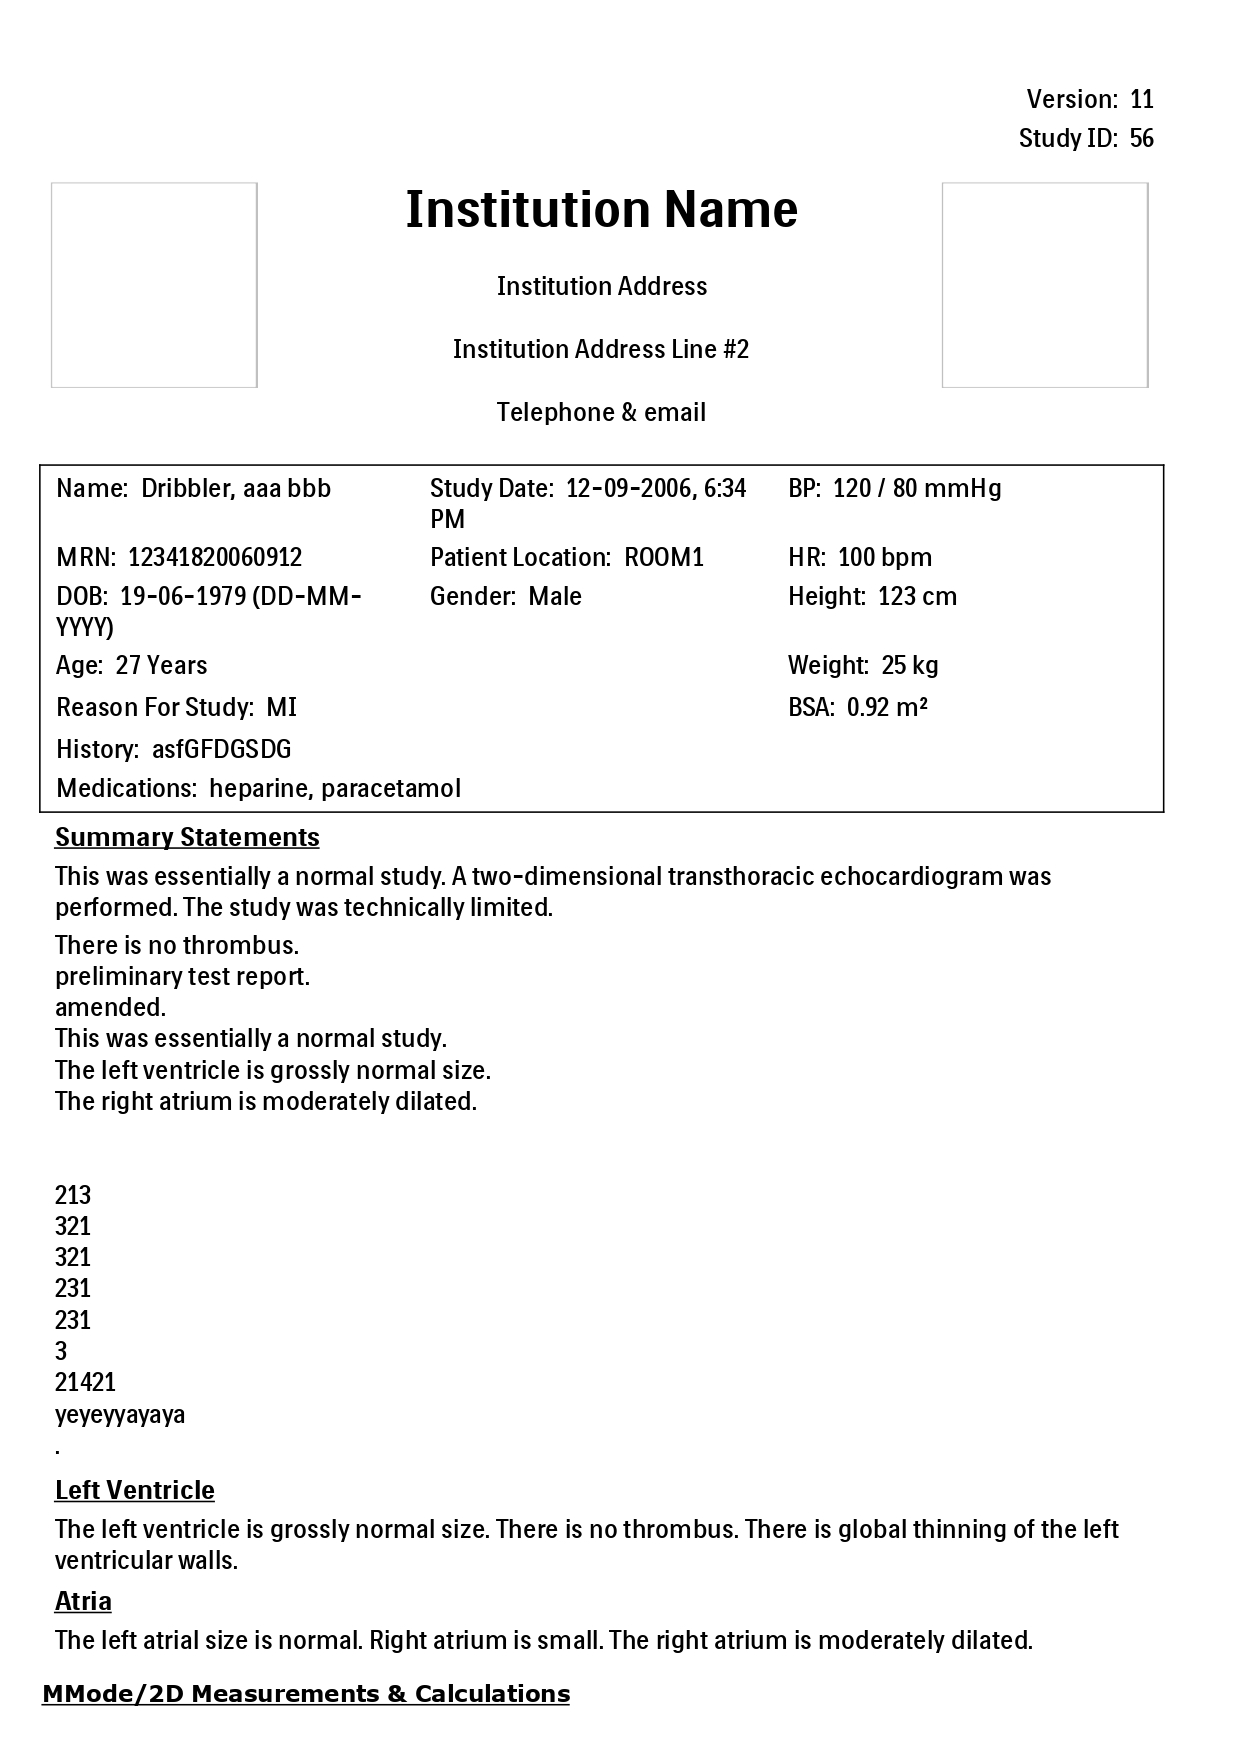

In [48]:
image_df = BinaryToImage().transform(bin_df)
display_images(image_df)


    Image #0:
    Origin: file:/usr/local/lib/python3.8/dist-packages/sparkocr/resources/ocr/forms/form1.jpg
    Resolution: 0 dpi
    Width: 1240 px
    Height: 1755 px
    Mode: ImageType.TYPE_3BYTE_BGR
    Number of channels: 3


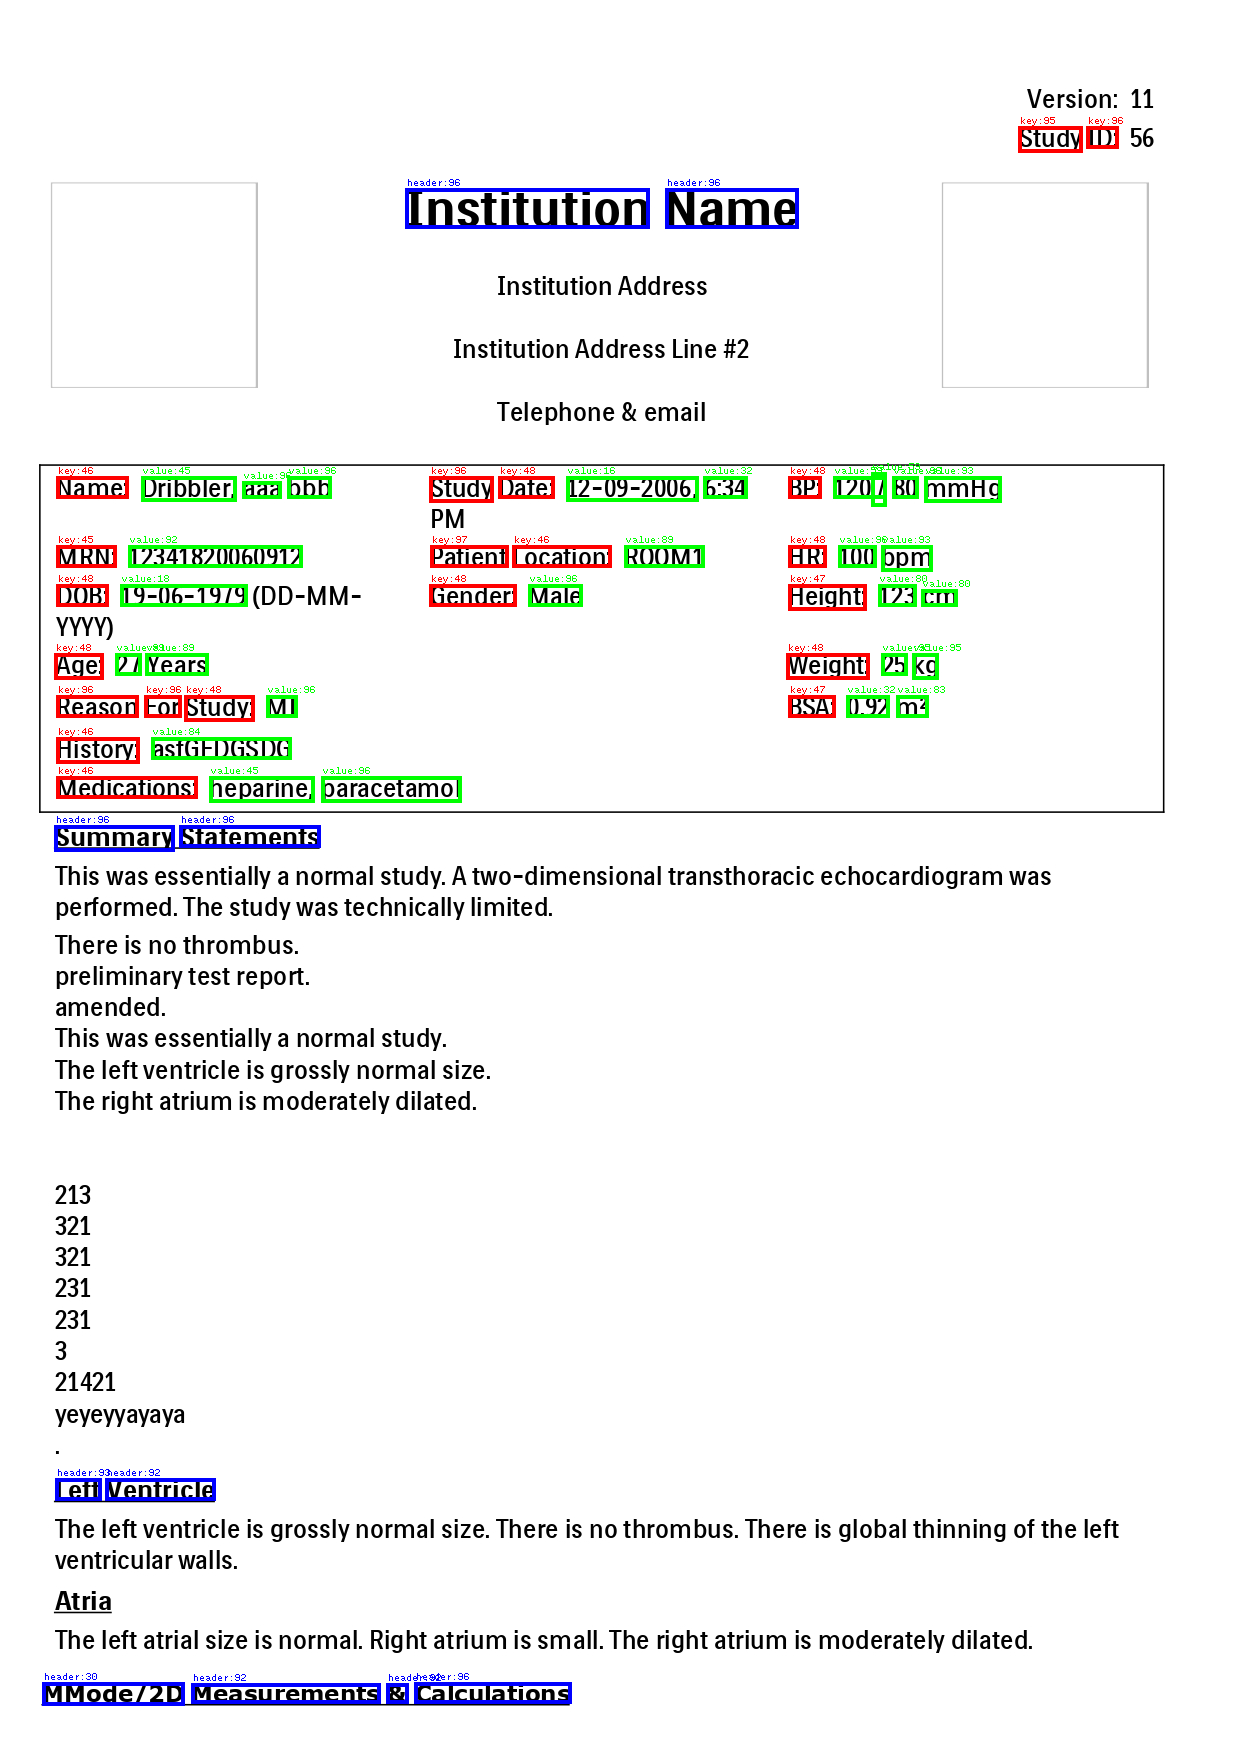

In [49]:
binary_to_image = BinaryToImage()\
    .setOutputCol("image") \
    .setImageType(ImageType.TYPE_3BYTE_BGR)

img_to_hocr = ImageToHocr()\
    .setInputCol("image")\
    .setOutputCol("hocr")\
    .setIgnoreResolution(False)\
    .setOcrParams(["preserve_interword_spaces=0"])

tokenizer = HocrTokenizer()\
    .setInputCol("hocr")\
    .setOutputCol("token")

doc_ner_cust = VisualDocumentNerV2()\
    .pretrained("layoutlmv2_key_value_pairs", "en", "clinical/ocr")\
    .setInputCols(["token", "image"])\
    .setOutputCol("entities")\
    .setLabels(["other",
                "header",
                "header",
                "key",
                "key",
                "value",
                "value"])\
    .setWhiteList(["header",
                   "key",
                   "value"])

draw = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("entities") \
    .setOutputCol("image_with_annotations") \
    .setFontSize(10) \
    .setLineWidth(4)\
    .setRectColor(Color.red)


# OCR pipeline
pipeline = PipelineModel(stages=[
    binary_to_image,
    img_to_hocr,
    tokenizer,
    doc_ner_cust,
    draw
])

results = pipeline.transform(bin_df).cache()
display_images(results, "image_with_annotations", width=1000)

In [50]:
pd_df = results.select('entities').toPandas().explode('entities')

pd_df['label'] = pd_df.entities.apply(lambda a : a[3])
pd_df['chunk'] = pd_df.entities.apply(lambda a : a[4]['word'])
pd_result = pd_df[pd_df['label'] != "O"][['label', 'chunk']].drop_duplicates()
pd_result

label           chunk
0     key           Study
0     key             ID:
0  header     Institution
0  header            Name
0     key           Name:
0   value       Dribbler,
0   value             aaa
0   value             bbb
0     key           Date:
0   value     12-09-2006,
0   value            6:34
0     key            MRN:
0   value  12341820060912
0     key         Patient
0     key       Location:
0   value           ROOM1
0     key            DOB:
0   value      19-06-1979
0     key         Gender:
0   value            Male
0     key            Age:
0   value              27
0   value           Years
0     key          Reason
0     key             For
0     key          Study:
0   value              MI
0     key        History:
0   value      asfGFDGSDG
0     key    Medications:
0   value       heparine,
0   value     paracetamol
0     key             BP:
0   value             120
0   value               /
0   value              80
0   value            mmHg
0     key             HR:
0   value             100
0   value             bpm
0     key         Height:
0   value             123
0   value              cm
0     key         Weight:
0   value              25
0   value              kg
0     key            BSA:
0   value            0.92
0   value              m2
0  header         Summary
0  header      Statements
0  header            Left
0  header       Ventricle
0  header        MMode/2D
0  header    Measurements
0  header               &
0  header    Calculations